In [35]:
%pip install numpy pandas matplotlib seaborn scikit-learn torch transformers tqdm nltk onnx onnxruntime

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [36]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
from sklearn.model_selection import GroupKFold
import random
import math
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set matplotlib styles
plt.style.use('seaborn-v0_8-whitegrid')

In [38]:
# Set the data path (adjust this to your specific environment)
data_path = 'Data/'  # Assuming files are in current directory

# Load the datasets
train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')
misconceptions_df = pd.read_csv(data_path + 'misconception_mapping.csv')
sample_submission_df = pd.read_csv(data_path + 'sample_submission.csv')

# Print basic information
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")
print(f"Misconceptions dataset shape: {misconceptions_df.shape}")
print(f"Sample submission shape: {sample_submission_df.shape}")

# Check the column names in each file to understand structure
print("\nColumns in train.csv:")
print(train_df.columns.tolist())

print("\nColumns in test.csv:")
print(test_df.columns.tolist())

print("\nColumns in misconception_mapping.csv:")
print(misconceptions_df.columns.tolist())

print("\nColumns in sample_submission.csv:")
print(sample_submission_df.columns.tolist())

Train dataset shape: (1869, 15)
Test dataset shape: (3, 11)
Misconceptions dataset shape: (2587, 2)
Sample submission shape: (9, 2)

Columns in train.csv:
['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText', 'MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']

Columns in test.csv:
['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']

Columns in misconception_mapping.csv:
['MisconceptionId', 'MisconceptionName']

Columns in sample_submission.csv:
['QuestionId_Answer', 'MisconceptionId']


In [39]:
# Display the first few rows of the train dataset
train_df.head()

,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId
0,0,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets,NaN,NaN,NaN,1672.00
1,1,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify,2142.00,143.00,2142.00,NaN
2,2,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct,1287.00,NaN,1287.00,1073.00
3,3,2377,Recall and use the intersecting diagonals prop...,88,Properties of Quadrilaterals,C,The angles highlighted on this rectangle with ...,acute,obtuse,\( 90^{\circ} \),Not enough information,1180.00,1180.00,NaN,1180.00
4,4,3387,Substitute positive integer values into formul...,67,Substitution into Formula,A,The equation \( f=3 r^{2}+3 \) is used to find...,\( 30 \),\( 27 \),\( 51 \),\( 24 \),NaN,NaN,NaN,1818.00


In [40]:
# Check the columns in the train dataset
print("Columns in the train dataset:")
print(train_df.columns.tolist())

# Check for missing values
print("\nMissing values in train dataset:")
print(train_df.isnull().sum())

# Basic statistics
print("\nBasic statistics of train dataset:")
print(train_df.describe(include='all'))

Columns in the train dataset:
['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText', 'MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']

Missing values in train dataset:
QuestionId            0
ConstructId           0
ConstructName         0
SubjectId             0
SubjectName           0
CorrectAnswer         0
QuestionText          0
AnswerAText           0
AnswerBText           0
AnswerCText           0
AnswerDText           0
MisconceptionAId    734
MisconceptionBId    751
MisconceptionCId    789
MisconceptionDId    832
dtype: int64

Basic statistics of train dataset:
        QuestionId  ConstructId                     ConstructName  SubjectId  \
count      1869.00      1869.00                              1869    1869.00   
unique         NaN          NaN                               757        NaN   
top            NaN          NaN  Calcul

In [41]:
# Display the first few rows of the test dataset
test_df.head()

,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText
0,1869,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets
1,1870,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify
2,1871,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct


In [42]:
# Check the columns in the test dataset
print("Columns in the test dataset:")
print(test_df.columns.tolist())

# Check for missing values
print("\nMissing values in test dataset:")
print(test_df.isnull().sum())

Columns in the test dataset:
['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']

Missing values in test dataset:
QuestionId       0
ConstructId      0
ConstructName    0
SubjectId        0
SubjectName      0
CorrectAnswer    0
QuestionText     0
AnswerAText      0
AnswerBText      0
AnswerCText      0
AnswerDText      0
dtype: int64


In [43]:
# Display the first few rows of each dataset to understand their structure
print("\nFirst few rows of train_df:")
display(train_df.head())

print("\nFirst few rows of test_df:")
display(test_df.head())

print("\nFirst few rows of misconceptions_df:")
display(misconceptions_df.head())

print("\nFirst few rows of sample_submission_df:")
display(sample_submission_df.head())


First few rows of train_df:


,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId
0,0,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets,NaN,NaN,NaN,1672.00
1,1,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify,2142.00,143.00,2142.00,NaN
2,2,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct,1287.00,NaN,1287.00,1073.00
3,3,2377,Recall and use the intersecting diagonals prop...,88,Properties of Quadrilaterals,C,The angles highlighted on this rectangle with ...,acute,obtuse,\( 90^{\circ} \),Not enough information,1180.00,1180.00,NaN,1180.00
4,4,3387,Substitute positive integer values into formul...,67,Substitution into Formula,A,The equation \( f=3 r^{2}+3 \) is used to find...,\( 30 \),\( 27 \),\( 51 \),\( 24 \),NaN,NaN,NaN,1818.00



First few rows of test_df:


,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText
0,1869,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets
1,1870,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify
2,1871,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct



First few rows of misconceptions_df:


,MisconceptionId,MisconceptionName
0,0,Does not know that angles in a triangle sum to...
1,1,Uses dividing fractions method for multiplying...
2,2,Believes there are 100 degrees in a full turn
3,3,Thinks a quadratic without a non variable term...
4,4,Believes addition of terms and powers of terms...



First few rows of sample_submission_df:


,QuestionId_Answer,MisconceptionId
0,1869_B,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,1869_C,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
2,1869_D,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
3,1870_A,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
4,1870_B,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...


In [44]:
# Check the columns in the misconceptions dataset
print("Columns in the misconceptions dataset:")
print(misconceptions_df.columns.tolist())

# Check for missing values
print("\nMissing values in misconceptions dataset:")
print(misconceptions_df.isnull().sum())

Columns in the misconceptions dataset:
['MisconceptionId', 'MisconceptionName']

Missing values in misconceptions dataset:
MisconceptionId      0
MisconceptionName    0
dtype: int64


In [45]:
# Display some random examples of misconceptions
misconceptions_df.sample(5)

,MisconceptionId,MisconceptionName
694,694,Confuses cubic and quadratic graphs
912,912,Thinks adding the same value to each side make...
1454,1454,Believes they can eliminate a variable without...
2242,2242,Converts a fraction to a decimal by placing th...
619,619,Divided by 10 rather than 100


In [46]:
# First, ensure we have the necessary columns
if 'QuestionId' in train_df.columns and 'MisconceptionId' in train_df.columns:
    # How many misconceptions are associated with each question in the training set?
    misconceptions_per_question = train_df.groupby('QuestionId')['MisconceptionId'].count()
    
    # Visualize the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(misconceptions_per_question, bins=20, kde=True)
    plt.title('Number of Misconceptions per Question')
    plt.xlabel('Count of Misconceptions')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Print statistics
    print(f"Average number of misconceptions per question: {misconceptions_per_question.mean():.2f}")
    print(f"Median number of misconceptions per question: {misconceptions_per_question.median()}")
    print(f"Max number of misconceptions per question: {misconceptions_per_question.max()}")
    
    # Additional analysis: Most common misconceptions
    misconception_counts = train_df['MisconceptionId'].value_counts()
    
    plt.figure(figsize=(12, 6))
    misconception_counts.head(15).plot(kind='bar')
    plt.title('Top 15 Most Common Misconceptions')
    plt.xlabel('Misconception ID')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Join with misconception descriptions if available
    if 'MisconceptionId' in misconceptions_df.columns:
        # Check for the column that contains misconception descriptions
        desc_column = None
        for col in misconceptions_df.columns:
            if 'text' in col.lower() or 'description' in col.lower():
                desc_column = col
                break
        
        if desc_column:
            # Show top misconceptions with their descriptions
            top_misconceptions = misconception_counts.head(10).index
            for mid in top_misconceptions:
                desc = misconceptions_df[misconceptions_df['MisconceptionId'] == mid][desc_column].values
                if len(desc) > 0:
                    print(f"Misconception ID {mid} (Count: {misconception_counts[mid]}):")
                    print(f"  Description: {desc[0]}")
                    print()
else:
    print("Required columns 'QuestionId' or 'MisconceptionId' not found in the training data.")
    print("Available columns:", train_df.columns.tolist())

Required columns 'QuestionId' or 'MisconceptionId' not found in the training data.
Available columns: ['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText', 'MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']


In [47]:
# First, let's check what columns we actually have in each file
print("Columns in train_df:", train_df.columns.tolist())
print("Columns in test_df:", test_df.columns.tolist())
print("Columns in misconceptions_df:", misconceptions_df.columns.tolist())
print("Columns in sample_submission_df:", sample_submission_df.columns.tolist())

# Let's also look at a few rows from each file
print("\nSample rows from train_df:")
display(train_df.head())

print("\nSample rows from misconceptions_df:")
display(misconceptions_df.head())

print("\nSample rows from test_df:")
display(test_df.head())

print("\nSample rows from sample_submission_df:")
display(sample_submission_df.head())

Columns in train_df: ['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText', 'MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']
Columns in test_df: ['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']
Columns in misconceptions_df: ['MisconceptionId', 'MisconceptionName']
Columns in sample_submission_df: ['QuestionId_Answer', 'MisconceptionId']

Sample rows from train_df:


,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId
0,0,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets,NaN,NaN,NaN,1672.00
1,1,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify,2142.00,143.00,2142.00,NaN
2,2,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct,1287.00,NaN,1287.00,1073.00
3,3,2377,Recall and use the intersecting diagonals prop...,88,Properties of Quadrilaterals,C,The angles highlighted on this rectangle with ...,acute,obtuse,\( 90^{\circ} \),Not enough information,1180.00,1180.00,NaN,1180.00
4,4,3387,Substitute positive integer values into formul...,67,Substitution into Formula,A,The equation \( f=3 r^{2}+3 \) is used to find...,\( 30 \),\( 27 \),\( 51 \),\( 24 \),NaN,NaN,NaN,1818.00



Sample rows from misconceptions_df:


,MisconceptionId,MisconceptionName
0,0,Does not know that angles in a triangle sum to...
1,1,Uses dividing fractions method for multiplying...
2,2,Believes there are 100 degrees in a full turn
3,3,Thinks a quadratic without a non variable term...
4,4,Believes addition of terms and powers of terms...



Sample rows from test_df:


,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText
0,1869,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets
1,1870,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify
2,1871,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct



Sample rows from sample_submission_df:


,QuestionId_Answer,MisconceptionId
0,1869_B,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,1869_C,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
2,1869_D,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
3,1870_A,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
4,1870_B,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...


In [48]:
# First, let's identify the correct column names in your data
print("Columns in train_df:", train_df.columns.tolist())
print("Columns in misconceptions_df:", misconceptions_df.columns.tolist())

# Try to identify misconception ID column (common variations)
misconception_id_col = None
potential_names = ['MisconceptionId', 'misconception_id', 'misconceptionid', 'Misconception', 'MiscID', 'misc_id']
for name in potential_names:
    if name in train_df.columns:
        misconception_id_col = name
        print(f"Found misconception ID column: '{name}'")
        break

if misconception_id_col is None:
    print("Could not find misconception ID column. Available columns:", train_df.columns.tolist())
    # Let's suggest the most likely column based on content
    for col in train_df.columns:
        if train_df[col].dtype in ['int64', 'int32'] and train_df[col].nunique() > 5:
            print(f"Potential misconception ID column: '{col}' (has {train_df[col].nunique()} unique values)")
else:
    # Compute misconception counts using the identified column
    misconception_counts = train_df[misconception_id_col].value_counts()
    
    # Now plot the top 20 misconceptions
    top_misconceptions = misconception_counts.head(20)
    
    plt.figure(figsize=(14, 7))
    top_misconceptions.plot(kind='bar')
    plt.title('Top 20 Most Common Misconceptions')
    plt.xlabel('Misconception ID')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Total unique misconceptions: {len(misconception_counts)}")
    print(f"Average frequency: {misconception_counts.mean():.2f}")
    print(f"Median frequency: {misconception_counts.median()}")
    print(f"Most common misconception appears {misconception_counts.max()} times")
    print(f"Number of misconceptions that appear only once: {sum(misconception_counts == 1)}")

Columns in train_df: ['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText', 'MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']
Columns in misconceptions_df: ['MisconceptionId', 'MisconceptionName']
Could not find misconception ID column. Available columns: ['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText', 'MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']
Potential misconception ID column: 'QuestionId' (has 1869 unique values)
Potential misconception ID column: 'ConstructId' (has 757 unique values)
Potential misconception ID column: 'SubjectId' (has 163 unique values)


SubjectId in train_df: True
ConstructId in train_df: True
SubjectId in test_df: True
ConstructId in test_df: True


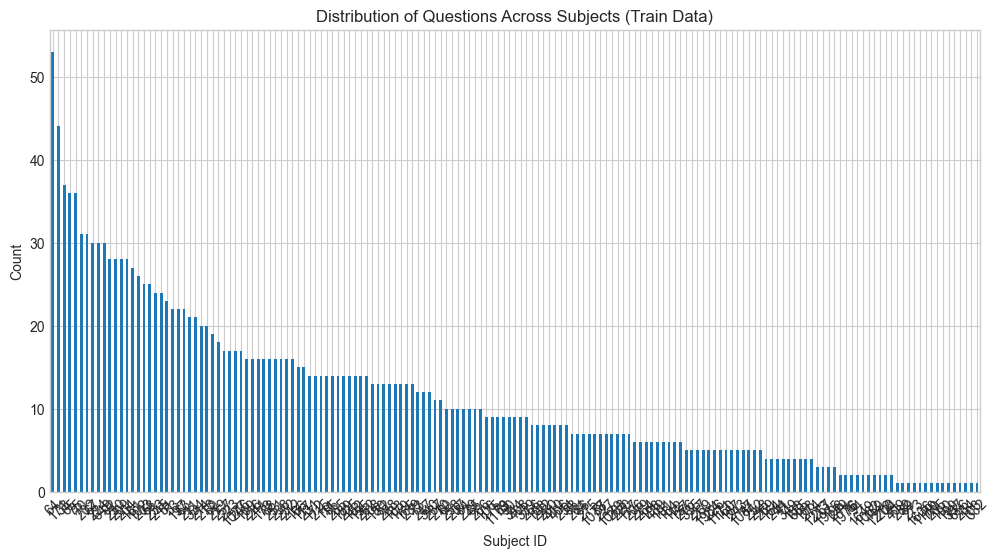

Number of different subjects: 163
Most common subject has 53 questions
Least common subject has 1 questions


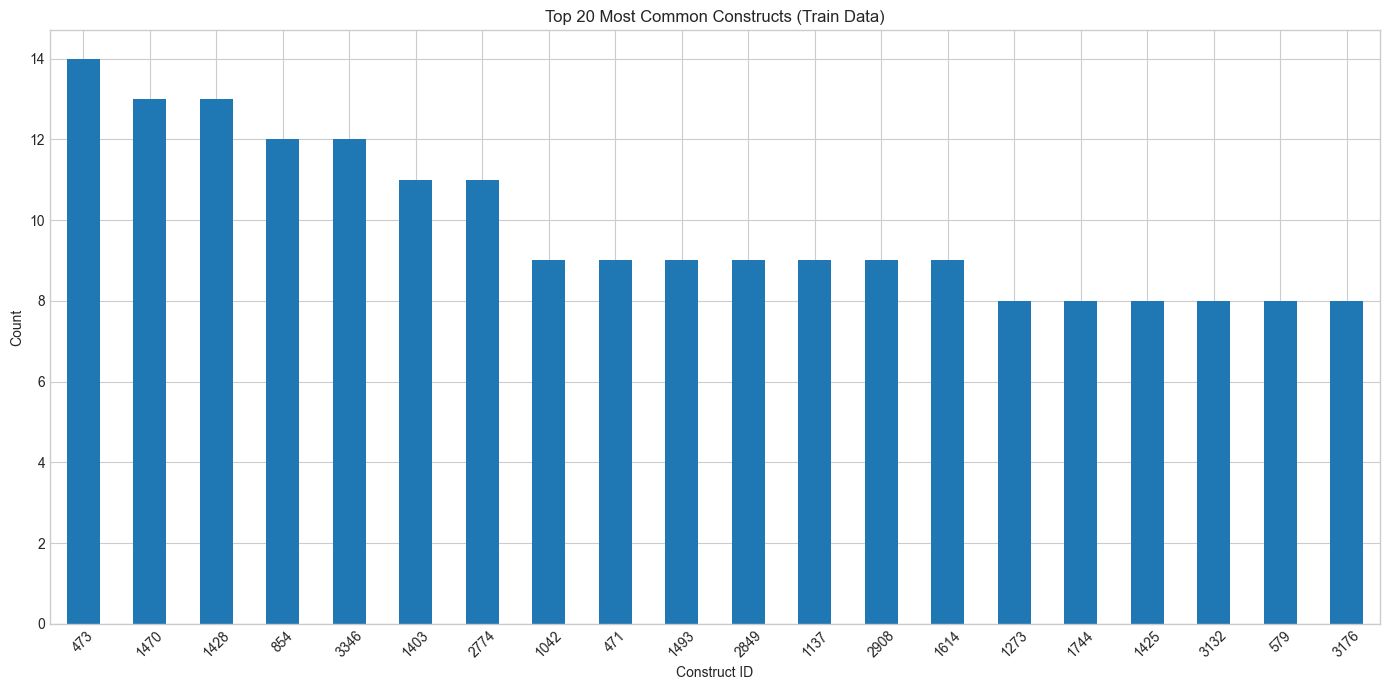

Number of different constructs: 757
Most common construct has 14 questions
Least common construct has 1 questions


In [49]:
# First, check if subject and construct information is available in your files
subject_in_train = 'SubjectId' in train_df.columns
construct_in_train = 'ConstructId' in train_df.columns
subject_in_test = 'SubjectId' in test_df.columns
construct_in_test = 'ConstructId' in test_df.columns

print(f"SubjectId in train_df: {subject_in_train}")
print(f"ConstructId in train_df: {construct_in_train}")
print(f"SubjectId in test_df: {subject_in_test}")
print(f"ConstructId in test_df: {construct_in_test}")

# If the columns exist in train data, plot distributions
if subject_in_train:
    # Distribution of questions across subjects in train data
    subject_counts = train_df['SubjectId'].value_counts()
    
    plt.figure(figsize=(12, 6))
    subject_counts.plot(kind='bar')
    plt.title('Distribution of Questions Across Subjects (Train Data)')
    plt.xlabel('Subject ID')
    plt.ylabel('Count')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()
    
    # Print subject distribution statistics
    print(f"Number of different subjects: {len(subject_counts)}")
    print(f"Most common subject has {subject_counts.max()} questions")
    print(f"Least common subject has {subject_counts.min()} questions")
else:
    print("SubjectId not found in train data")

if construct_in_train:
    # Distribution of questions across constructs in train data
    construct_counts = train_df['ConstructId'].value_counts()
    
    plt.figure(figsize=(14, 7))
    top_constructs = construct_counts.head(20)
    top_constructs.plot(kind='bar')
    plt.title('Top 20 Most Common Constructs (Train Data)')
    plt.xlabel('Construct ID')
    plt.ylabel('Count')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print construct distribution statistics
    print(f"Number of different constructs: {len(construct_counts)}")
    print(f"Most common construct has {construct_counts.max()} questions")
    print(f"Least common construct has {construct_counts.min()} questions")
else:
    print("ConstructId not found in train data")

# If columns only exist in test data, analyze those instead
if not subject_in_train and subject_in_test:
    # Distribution of questions across subjects in test data
    subject_counts = test_df['SubjectId'].value_counts()
    
    plt.figure(figsize=(12, 6))
    subject_counts.plot(kind='bar')
    plt.title('Distribution of Questions Across Subjects (Test Data)')
    plt.xlabel('Subject ID')
    plt.ylabel('Count')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

if not construct_in_train and construct_in_test:
    # Distribution of questions across constructs in test data
    construct_counts = test_df['ConstructId'].value_counts()
    
    plt.figure(figsize=(14, 7))
    top_constructs = construct_counts.head(20)
    top_constructs.plot(kind='bar')
    plt.title('Top 20 Most Common Constructs (Test Data)')
    plt.xlabel('Construct ID')
    plt.ylabel('Count')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# If neither train nor test data has these columns, suggest alternatives
if not (subject_in_train or subject_in_test):
    print("Subject information not found in any dataset. Consider exploring other columns.")
    # List columns that might be alternatives
    print("Available columns in train_df:", train_df.columns.tolist())
    print("Available columns in test_df:", test_df.columns.tolist())
    
    # Suggest alternative analyses based on available columns
    categorical_cols = [col for col in train_df.columns if train_df[col].dtype == 'object' or train_df[col].nunique() < 50]
    if categorical_cols:
        print("\nPossible categorical columns to analyze instead:", categorical_cols)
        
        # Select first categorical column as an example
        example_col = categorical_cols[0]
        example_counts = train_df[example_col].value_counts()
        
        plt.figure(figsize=(12, 6))
        example_counts.head(20).plot(kind='bar')
        plt.title(f'Distribution of {example_col} in Train Data')
        plt.xlabel(example_col)
        plt.ylabel('Count')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

Using column 'QuestionText' for question text analysis


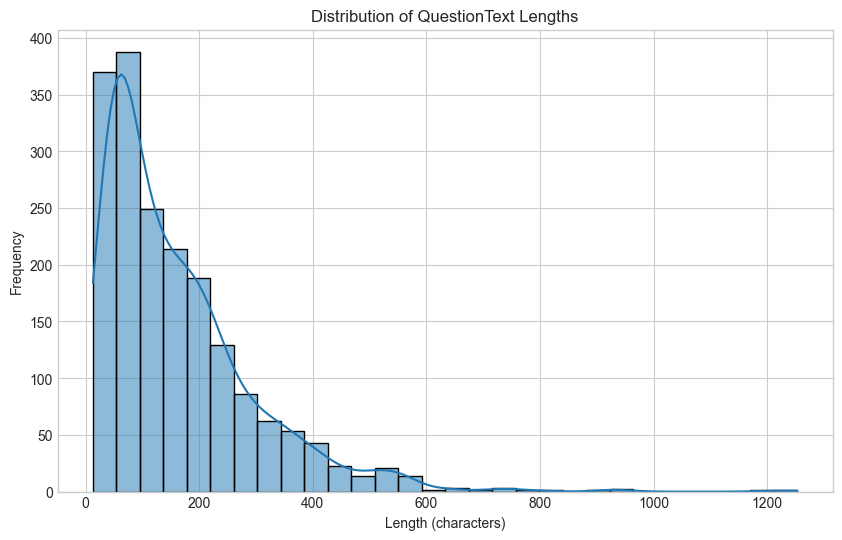

Average QuestionText length: 160.60 characters
Median QuestionText length: 121.0 characters
Max QuestionText length: 1253 characters

No misconception text column found in misconceptions_df.
Available columns in misconceptions_df: ['MisconceptionId', 'MisconceptionName']

Fallback: Analyzing misconception IDs using column 'MisconceptionId'
Total unique misconceptions: 2587


In [50]:
# Check for question text columns in train_df and test_df
question_text_cols = []
for col in train_df.columns:
    if 'question' in col.lower() and 'text' in col.lower():
        question_text_cols.append(col)
if not question_text_cols:
    for col in test_df.columns:
        if 'question' in col.lower() and 'text' in col.lower():
            question_text_cols.append(col)

# Check for misconception text column in misconceptions_df
misconception_text_col = None
for col in misconceptions_df.columns:
    if 'text' in col.lower() or 'description' in col.lower():
        misconception_text_col = col
        break

# Length distribution of question texts (if available)
if question_text_cols:
    # Use the first matching column
    question_text_col = question_text_cols[0]
    print(f"Using column '{question_text_col}' for question text analysis")
    
    # Determine which dataframe has this column
    if question_text_col in train_df.columns:
        df_with_questions = train_df
    else:
        df_with_questions = test_df
    
    # Calculate text lengths
    df_with_questions[f'{question_text_col}Length'] = df_with_questions[question_text_col].apply(lambda x: len(str(x)))
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df_with_questions[f'{question_text_col}Length'].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of {question_text_col} Lengths')
    plt.xlabel('Length (characters)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Print statistics
    length_data = df_with_questions[f'{question_text_col}Length'].dropna()
    print(f"Average {question_text_col} length: {length_data.mean():.2f} characters")
    print(f"Median {question_text_col} length: {length_data.median()} characters")
    print(f"Max {question_text_col} length: {length_data.max()} characters")
else:
    print("No question text column found in available dataframes.")
    print("Available columns in train_df:", train_df.columns.tolist())
    print("Available columns in test_df:", test_df.columns.tolist())

# Length distribution of misconception texts
if misconception_text_col:
    print(f"\nUsing column '{misconception_text_col}' for misconception text analysis")
    
    # Calculate text lengths
    misconceptions_df['MisconceptionTextLength'] = misconceptions_df[misconception_text_col].apply(lambda x: len(str(x)))
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(misconceptions_df['MisconceptionTextLength'].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of {misconception_text_col} Lengths')
    plt.xlabel('Length (characters)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Print statistics
    length_data = misconceptions_df['MisconceptionTextLength'].dropna()
    print(f"Average misconception text length: {length_data.mean():.2f} characters")
    print(f"Median misconception text length: {length_data.median()} characters")
    print(f"Max misconception text length: {length_data.max()} characters")
else:
    print("\nNo misconception text column found in misconceptions_df.")
    print("Available columns in misconceptions_df:", misconceptions_df.columns.tolist())
    
    # Provide a fallback analysis on misconception IDs if text isn't available
    if 'MisconceptionId' in misconceptions_df.columns or any('misconception' in col.lower() for col in misconceptions_df.columns):
        mid_col = 'MisconceptionId' if 'MisconceptionId' in misconceptions_df.columns else [col for col in misconceptions_df.columns if 'misconception' in col.lower()][0]
        
        print(f"\nFallback: Analyzing misconception IDs using column '{mid_col}'")
        print(f"Total unique misconceptions: {misconceptions_df[mid_col].nunique()}")
        
        # Plot distribution of misconception frequencies if we have train data with this column
        if mid_col in train_df.columns:
            misconception_counts = train_df[mid_col].value_counts()
            
            plt.figure(figsize=(10, 6))
            sns.histplot(misconception_counts, bins=20, kde=True)
            plt.title('Distribution of Misconception Frequencies')
            plt.xlabel('Frequency')
            plt.ylabel('Count')
            plt.grid(True)
            plt.show()

In [51]:
# First, let's check what columns we have in our dataframes
print("Columns in train_df:", train_df.columns.tolist())
print("Columns in misconceptions_df:", misconceptions_df.columns.tolist())

# Identify relevant column names
# Check for question ID column
question_id_col = None
for col in train_df.columns:
    if 'question' in col.lower() and 'id' in col.lower():
        question_id_col = col
        break

# Check for misconception ID column
misconception_id_col = None
for col in train_df.columns:
    if 'misconception' in col.lower() and 'id' in col.lower():
        misconception_id_col = col
        break

# Check if we need to merge with another file for question text
question_text_in_train = any('text' in col.lower() and 'question' in col.lower() for col in train_df.columns)
if not question_text_in_train:
    print("Question text not found in train_df. Cannot merge with questions_df as it's not available.")
    print("Available data can only be analyzed based on IDs.")

# Check for question text and answer text columns
question_text_col = None
answer_text_col = None
for col in train_df.columns:
    if 'question' in col.lower() and 'text' in col.lower():
        question_text_col = col
    if 'answer' in col.lower() and 'text' in col.lower():
        answer_text_col = col

# Check for misconception text column
misconception_text_col = None
for col in misconceptions_df.columns:
    if 'text' in col.lower() or 'description' in col.lower():
        misconception_text_col = col
        break

# If we have the necessary columns, sample some records
if question_id_col and misconception_id_col:
    # Sample directly from train_df without merging
    sample_records = train_df.sample(5)
    
    for _, row in sample_records.iterrows():
        print(f"Question ID: {row[question_id_col]}")
        
        # Print question text if available
        if question_text_col and question_text_col in row:
            print(f"Question: {row[question_text_col]}")
        
        # Print answer text if available
        if answer_text_col and answer_text_col in row:
            print(f"Answer: {row[answer_text_col]}")
        
        # Get the misconception information if available
        if misconception_id_col in row and misconception_text_col:
            try:
                misconception = misconceptions_df[misconceptions_df[misconception_id_col] == row[misconception_id_col]]
                if not misconception.empty:
                    print(f"Misconception ID: {row[misconception_id_col]}")
                    print(f"Misconception: {misconception.iloc[0][misconception_text_col]}")
                else:
                    print(f"Misconception ID: {row[misconception_id_col]}")
                    print(f"Misconception: [Not found in misconceptions_df]")
            except Exception as e:
                print(f"Error retrieving misconception: {str(e)}")
        
        print("-" * 100)
else:
    print("Required ID columns not found. Cannot analyze relationships between questions and misconceptions.")
    print(f"Looking for question ID column like 'QuestionId' and misconception ID column like 'MisconceptionId'")

Columns in train_df: ['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText', 'MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId', 'QuestionTextLength']
Columns in misconceptions_df: ['MisconceptionId', 'MisconceptionName']
Question ID: 878
Question: 65
Answer: \( 2 \)
----------------------------------------------------------------------------------------------------
Question ID: 818
Question: 40
Answer: \( 20 \)
----------------------------------------------------------------------------------------------------
Question ID: 663
Question: 323
Answer: There are \( 8 \) lots of \( 25 \) in \( 100 \)
Then I multiplied \( 8 \) by \( 6 \) 
So the answer is \( 48 \)
----------------------------------------------------------------------------------------------------
Question ID: 1348
Question: 91
Answer: The triangle numbers
-------------------------------

In [52]:
# First, let's check the columns and size of your test dataframe
print("Columns in test_df:", test_df.columns.tolist())
print(f"Number of rows in test_df: {len(test_df)}")

# Sample some records from the test set, making sure not to request more than available
sample_size = min(5, len(test_df))
if sample_size > 0:
    test_samples = test_df.sample(sample_size)
    print(f"\nSample records from test data ({sample_size} samples):")
    display(test_samples)
else:
    print("\nTest dataset is empty, cannot sample records")
    
# Let's also check the size of other dataframes for reference
print(f"\nNumber of rows in train_df: {len(train_df)}")
print(f"Number of rows in misconceptions_df: {len(misconceptions_df)}")

# Display the first few rows of each dataframe instead of sampling
print("\nFirst few rows of train_df:")
display(train_df.head(2))

print("\nFirst few rows of test_df:")
display(test_df.head(2))

print("\nFirst few rows of misconceptions_df:")
display(misconceptions_df.head(2))

Columns in test_df: ['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId', 'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']
Number of rows in test_df: 3

Sample records from test data (3 samples):


,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText
0,1869,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets
1,1870,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify
2,1871,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct



Number of rows in train_df: 1869
Number of rows in misconceptions_df: 2587

First few rows of train_df:


,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId,QuestionTextLength
0,0,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets,NaN,NaN,NaN,1672.00,89
1,1,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify,2142.00,143.00,2142.00,NaN,66



First few rows of test_df:


,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText
0,1869,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets
1,1870,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify



First few rows of misconceptions_df:


,MisconceptionId,MisconceptionName
0,0,Does not know that angles in a triangle sum to...
1,1,Uses dividing fractions method for multiplying...


In [53]:
# Check if there are any QuestionIds in the test set that are not in the training set
test_only_questions = set(test_df['QuestionId']) - set(train_df['QuestionId'])
print(f"Number of questions only in the test set: {len(test_only_questions)}")

# Check if there are any QuestionIds in the training set that are not in the test set
train_only_questions = set(train_df['QuestionId']) - set(test_df['QuestionId'])
print(f"Number of questions only in the training set: {len(train_only_questions)}")

Number of questions only in the test set: 3
Number of questions only in the training set: 1869


##SECTION-2

In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GroupKFold, StratifiedKFold
import random
import math
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rishichhabra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rishichhabra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rishichhabra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [55]:
def clean_text(text):
    """
    Clean text by removing special characters, extra spaces, etc.
    """
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove HTML tags if any
        text = re.sub(r'<.*?>', '', text)
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        
        # Remove special characters and numbers (keeping math symbols)
        # We keep +, -, *, /, =, <, >, (, ), [, ], {, }, ^, √ as they're important for math
        text = re.sub(r'[^\w\s+\-*/=<>()[\]{}\^√]', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    else:
        return ""

def preprocess_text(text, remove_stopwords=False, lemmatize=False):
    """
    Preprocess text with optional stopword removal and lemmatization.
    """
    if not isinstance(text, str) or text == "":
        return ""
    
    # Clean the text first
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords if requested
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize if requested
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [ ]:
# Create cross-validation splits adapted to your dataset structure
def create_validation_splits(df, id_column, n_splits=5, method='group'):
    """
    Create validation splits for cross-validation.
    
    Args:
        df: DataFrame containing the training data
        id_column: Column name to use for grouping (e.g., question_id_col or misconception_id_col)
        n_splits: Number of splits to create
        method: Method to use for splitting ('group' or 'stratified')
    
    Returns:
        List of (train_idx, valid_idx) pairs for each fold
    """
    if id_column not in df.columns:
        print(f"Column {id_column} not found in dataframe")
        return []
        
    if method == 'group':
        # Use GroupKFold to ensure related items stay together
        cv = GroupKFold(n_splits=n_splits)
        splits = list(cv.split(df, groups=df[id_column]))
    elif method == 'stratified':
        # Use StratifiedKFold to maintain the distribution
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        splits = list(cv.split(df, df[id_column]))
    else:
        raise ValueError(f"Unknown split method: {method}")
    
    return splits

def create_custom_unseen_split(df, id_column, unseen_ratio=0.2, random_state=42):
    """
    Create a custom train/validation split where some items are completely held out.
    
    Args:
        df: DataFrame containing the training data
        id_column: Column to use for creating the unseen split
        unseen_ratio: Proportion to hold out
        random_state: Random seed for reproducibility
    
    Returns:
        train_idx, valid_idx: Indices for training and validation sets
    """
    if id_column not in df.columns:
        print(f"Column {id_column} not found in dataframe")
        return [], []
        
    # Get unique values
    unique_values = df[id_column].unique()
    
    # Set random seed
    np.random.seed(random_state)
    
    # Randomly select values to hold out
    n_unseen = int(len(unique_values) * unseen_ratio)
    unseen_values = np.random.choice(unique_values, size=n_unseen, replace=False)
    
    # Create train and validation indices
    train_idx = df[~df[id_column].isin(unseen_values)].index
    valid_idx = df[df[id_column].isin(unseen_values)].index
    
    return train_idx, valid_idx

# Apply the functions using the identified columns
if question_id_col and misconception_id_col:
    # Choose which column to use for splits (usually misconception ID for this task)
    split_column = misconception_id_col
    
    # Create standard cross-validation splits
    group_splits = create_validation_splits(train_df, split_column, method='group')
    stratified_splits = create_validation_splits(train_df, split_column, method='stratified')
    
    # Create a custom split with unseen items
    unseen_train_idx, unseen_valid_idx = create_custom_unseen_split(train_df, split_column, unseen_ratio=0.2)
    
    # Analyze the splits
    if group_splits:
        print("\nStandard GroupKFold splits:")
        for fold, (train_idx, valid_idx) in enumerate(group_splits):
            train_values = set(train_df.iloc[train_idx][split_column])
            valid_values = set(train_df.iloc[valid_idx][split_column])
            unseen_values = valid_values - train_values
            
            print(f"Fold {fold+1}:")
            print(f"  Train set size: {len(train_idx)}")
            print(f"  Validation set size: {len(valid_idx)}")
            print(f"  Number of unseen values in validation: {len(unseen_values)}")
            print(f"  Proportion of unseen values: {len(unseen_values) / len(valid_values):.2f}")
    
    print("\nCustom split with unseen values:")
    if len(unseen_train_idx) > 0 and len(unseen_valid_idx) > 0:
        train_values = set(train_df.iloc[unseen_train_idx][split_column])
        valid_values = set(train_df.iloc[unseen_valid_idx][split_column])
        unseen_values = valid_values - train_values
        
        print(f"Train set size: {len(unseen_train_idx)}")
        print(f"Validation set size: {len(unseen_valid_idx)}")
        print(f"Number of unseen values in validation: {len(unseen_values)}")
        print(f"Proportion of unseen values: {len(unseen_values) / len(valid_values):.2f}")
else:
    print("Cannot create validation splits: Required ID columns not found")

In [ ]:
def create_query(row, include_subject=True, include_construct=True):
    """
    Create a query representation from a row containing question and answer information.
    """
    # Start with the question text
    query_parts = []
    
    # Add subject and construct if available and requested
    if include_subject and 'SubjectId' in row and pd.notna(row['SubjectId']):
        query_parts.append(f"Subject: {row['SubjectId']}")
    
    if include_construct and 'ConstructId' in row and pd.notna(row['ConstructId']):
        query_parts.append(f"Construct: {row['ConstructId']}")
    
    # Add question text
    if 'QuestionText' in row and pd.notna(row['QuestionText']):
        query_parts.append(f"Question: {row['QuestionText']}")
    
    # Add answer text (the incorrect answer)
    if 'AnswerText' in row and pd.notna(row['AnswerText']):
        query_parts.append(f"Incorrect Answer: {row['AnswerText']}")
    
    # Join all parts
    query = " ".join(query_parts)
    
    return query

In [ ]:
# Merge datasets to get all necessary information
train_with_questions = train_df.merge(questions_df, on='QuestionId', how='left')
test_with_questions = test_df.merge(questions_df, on='QuestionId', how='left')

# Create query representations
train_with_questions['Query'] = train_with_questions.apply(create_query, axis=1)
test_with_questions['Query'] = test_with_questions.apply(create_query, axis=1)

# Check a few examples
print("Sample query representations from training data:")
for i, row in train_with_questions.sample(3).iterrows():
    print(f"Query: {row['Query']}")
    # Get the misconception text
    misconception = misconceptions_df[misconceptions_df['MisconceptionId'] == row['MisconceptionId']].iloc[0]
    print(f"Associated Misconception: {misconception['MisconceptionText']}")
    print("-" * 80)

In [ ]:
# Preprocess queries in train and test sets
train_with_questions['ProcessedQuery'] = train_with_questions['Query'].apply(
    lambda x: preprocess_text(x, remove_stopwords=False, lemmatize=True)
)
test_with_questions['ProcessedQuery'] = test_with_questions['Query'].apply(
    lambda x: preprocess_text(x, remove_stopwords=False, lemmatize=True)
)

# Preprocess misconception texts
misconceptions_df['ProcessedMisconceptionText'] = misconceptions_df['MisconceptionText'].apply(
    lambda x: preprocess_text(x, remove_stopwords=False, lemmatize=True)
)

# Check some examples of processed texts
print("Sample processed queries from training data:")
for query, processed in zip(train_with_questions['Query'].head(3), 
                          train_with_questions['ProcessedQuery'].head(3)):
    print(f"Original: {query}")
    print(f"Processed: {processed}")
    print("-" * 80)

print("\nSample processed misconception texts:")
for original, processed in zip(misconceptions_df['MisconceptionText'].head(3), 
                             misconceptions_df['ProcessedMisconceptionText'].head(3)):
    print(f"Original: {original}")
    print(f"Processed: {processed}")
    print("-" * 80)

In [ ]:
def create_validation_splits(df, n_splits=5, method='group'):
    """
    Create validation splits for cross-validation.
    
    Args:
        df: DataFrame containing the training data
        n_splits: Number of splits to create
        method: Method to use for splitting ('group' or 'stratified')
    
    Returns:
        List of (train_idx, valid_idx) pairs for each fold
    """
    if method == 'group':
        # Use GroupKFold to ensure related items stay together
        cv = GroupKFold(n_splits=n_splits)
        splits = list(cv.split(df, groups=df['MisconceptionId']))
    elif method == 'stratified':
        # Use StratifiedKFold to maintain the distribution of misconceptions
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        splits = list(cv.split(df, df['MisconceptionId']))
    else:
        raise ValueError(f"Unknown split method: {method}")
    
    return splits

In [ ]:
def create_custom_unseen_split(df, unseen_ratio=0.2, random_state=42):
    """
    Create a custom train/validation split where some misconceptions are completely held out
    from the training set to simulate "unseen" misconceptions.
    
    Args:
        df: DataFrame containing the training data
        unseen_ratio: Proportion of misconceptions to hold out
        random_state: Random seed for reproducibility
    
    Returns:
        train_idx, valid_idx: Indices for training and validation sets
    """
    # Get unique misconceptions
    unique_misconceptions = df['MisconceptionId'].unique()
    
    # Set random seed
    np.random.seed(random_state)
    
    # Randomly select misconceptions to hold out
    n_unseen = int(len(unique_misconceptions) * unseen_ratio)
    unseen_misconceptions = np.random.choice(unique_misconceptions, size=n_unseen, replace=False)
    
    # Create train and validation indices
    train_idx = df[~df['MisconceptionId'].isin(unseen_misconceptions)].index
    valid_idx = df[df['MisconceptionId'].isin(unseen_misconceptions)].index
    
    return train_idx, valid_idx

In [ ]:
# Create standard cross-validation splits
group_splits = create_validation_splits(train_with_questions, method='group')
stratified_splits = create_validation_splits(train_with_questions, method='stratified')

# Create a custom split with unseen misconceptions
unseen_train_idx, unseen_valid_idx = create_custom_unseen_split(train_with_questions, unseen_ratio=0.2)

# Analyze the splits
print("Standard GroupKFold splits:")
for fold, (train_idx, valid_idx) in enumerate(group_splits):
    train_misconceptions = set(train_with_questions.iloc[train_idx]['MisconceptionId'])
    valid_misconceptions = set(train_with_questions.iloc[valid_idx]['MisconceptionId'])
    unseen_misconceptions = valid_misconceptions - train_misconceptions
    
    print(f"Fold {fold+1}:")
    print(f"  Train set size: {len(train_idx)}")
    print(f"  Validation set size: {len(valid_idx)}")
    print(f"  Number of unseen misconceptions in validation: {len(unseen_misconceptions)}")
    print(f"  Proportion of unseen misconceptions: {len(unseen_misconceptions) / len(valid_misconceptions):.2f}")

print("\nCustom split with unseen misconceptions:")
train_misconceptions = set(train_with_questions.iloc[unseen_train_idx]['MisconceptionId'])
valid_misconceptions = set(train_with_questions.iloc[unseen_valid_idx]['MisconceptionId'])
unseen_misconceptions = valid_misconceptions - train_misconceptions

print(f"Train set size: {len(unseen_train_idx)}")
print(f"Validation set size: {len(unseen_valid_idx)}")
print(f"Number of unseen misconceptions in validation: {len(unseen_misconceptions)}")
print(f"Proportion of unseen misconceptions: {len(unseen_misconceptions) / len(valid_misconceptions):.2f}")

In [ ]:
# Prepare the training data with the necessary columns
preprocessed_train = train_with_questions[['QuestionId', 'MisconceptionId', 'Query', 'ProcessedQuery']]

# Prepare the test data
preprocessed_test = test_with_questions[['QuestionId', 'Query', 'ProcessedQuery']]

# Prepare the misconceptions data
preprocessed_misconceptions = misconceptions_df[['MisconceptionId', 'MisconceptionText', 'ProcessedMisconceptionText']]

# Check the shapes of the final datasets
print(f"Preprocessed train dataset shape: {preprocessed_train.shape}")
print(f"Preprocessed test dataset shape: {preprocessed_test.shape}")
print(f"Preprocessed misconceptions dataset shape: {preprocessed_misconceptions.shape}")

In [ ]:
# Create a mapping from misconception IDs to numerical indices
misconception_to_idx = {mid: idx for idx, mid in enumerate(misconceptions_df['MisconceptionId'].unique())}
idx_to_misconception = {idx: mid for mid, idx in misconception_to_idx.items()}

# Add encoded misconception IDs to the dataframes
preprocessed_train['MisconceptionIdx'] = preprocessed_train['MisconceptionId'].map(misconception_to_idx)
preprocessed_misconceptions['MisconceptionIdx'] = preprocessed_misconceptions['MisconceptionId'].map(misconception_to_idx)

# Check the encodings
print("Sample misconception encodings:")
print(preprocessed_misconceptions[['MisconceptionId', 'MisconceptionIdx']].head())

In [ ]:
def create_training_pairs(train_df, misconceptions_df, n_negatives=5, seed=42):
    """
    Create training pairs with positive and negative examples.
    
    Args:
        train_df: Preprocessed training dataframe
        misconceptions_df: Preprocessed misconceptions dataframe
        n_negatives: Number of negative examples per positive
        seed: Random seed for reproducibility
    
    Returns:
        DataFrame with query, positive misconception, and negative misconceptions
    """
    np.random.seed(seed)
    
    # Get all unique misconception IDs
    all_misconception_ids = misconceptions_df['MisconceptionId'].unique()
    
    # Initialize lists to store data
    data = []
    
    # Group by QuestionId to keep track of positive misconceptions
    for question_id, group in train_df.groupby('QuestionId'):
        # Get the positive misconceptions for this question
        positive_misconceptions = group['MisconceptionId'].tolist()
        
        # Get the query for this question (should be the same for all rows)
        query = group['Query'].iloc[0]
        processed_query = group['ProcessedQuery'].iloc[0]
        
        # For each positive misconception, sample negative misconceptions
        for pos_mid in positive_misconceptions:
            # Get the processed text for the positive misconception
            pos_misconception_text = misconceptions_df[misconceptions_df['MisconceptionId'] == pos_mid]['MisconceptionText'].iloc[0]
            pos_processed_text = misconceptions_df[misconceptions_df['MisconceptionId'] == pos_mid]['ProcessedMisconceptionText'].iloc[0]
            
            # Sample negative misconceptions (those not positive for this question)
            negative_misconception_ids = np.random.choice(
                [mid for mid in all_misconception_ids if mid not in positive_misconceptions],
                size=min(n_negatives, len(all_misconception_ids) - len(positive_misconceptions)),
                replace=False
            )
            
            # Get the text for the negative misconceptions
            negative_misconceptions = []
            for neg_mid in negative_misconception_ids:
                neg_misconception_text = misconceptions_df[misconceptions_df['MisconceptionId'] == neg_mid]['MisconceptionText'].iloc[0]
                neg_processed_text = misconceptions_df[misconceptions_df['MisconceptionId'] == neg_mid]['ProcessedMisconceptionText'].iloc[0]
                
                negative_misconceptions.append({
                    'MisconceptionId': neg_mid,
                    'MisconceptionText': neg_misconception_text,
                    'ProcessedMisconceptionText': neg_processed_text
                })
            
            # Add the data point
            data.append({
                'QuestionId': question_id,
                'Query': query,
                'ProcessedQuery': processed_query,
                'PositiveMisconceptionId': pos_mid,
                'PositiveMisconceptionText': pos_misconception_text,
                'ProcessedPositiveMisconceptionText': pos_processed_text,
                'NegativeMisconceptions': negative_misconceptions
            })
    
    return pd.DataFrame(data)

In [ ]:
# Create training pairs with positive and negative examples
training_pairs = create_training_pairs(preprocessed_train, preprocessed_misconceptions, n_negatives=5)

# Check the structure of the training pairs
print(f"Training pairs shape: {training_pairs.shape}")
print("\nSample training pair:")
sample_pair = training_pairs.iloc[0]
print(f"Question ID: {sample_pair['QuestionId']}")
print(f"Query: {sample_pair['Query']}")
print(f"Positive Misconception ID: {sample_pair['PositiveMisconceptionId']}")
print(f"Positive Misconception Text: {sample_pair['PositiveMisconceptionText']}")
print("\nNegative Misconceptions:")
for i, neg_misc in enumerate(sample_pair['NegativeMisconceptions']):
    print(f"  {i+1}. ID: {neg_misc['MisconceptionId']}, Text: {neg_misc['MisconceptionText']}")

In [ ]:
# Prepare final datasets for saving
train_data = {
    'preprocessed_train': preprocessed_train,
    'preprocessed_test': preprocessed_test,
    'preprocessed_misconceptions': preprocessed_misconceptions,
    'training_pairs': training_pairs,
    'cv_splits': {
        'group_splits': group_splits,
        'stratified_splits': stratified_splits,
        'unseen_split': (unseen_train_idx, unseen_valid_idx)
    },
    'encodings': {
        'misconception_to_idx': misconception_to_idx,
        'idx_to_misconception': idx_to_misconception
    }
}

# In a real environment, you'd save these datasets to disk
# For Kaggle, you might save to a pickle file
import pickle

with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

print("Preprocessed data saved for next steps.")

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import average_precision_score
import pickle
import random
import os
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
# Load preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

preprocessed_train = train_data['preprocessed_train']
preprocessed_test = train_data['preprocessed_test']
preprocessed_misconceptions = train_data['preprocessed_misconceptions']
training_pairs = train_data['training_pairs']
cv_splits = train_data['cv_splits']
misconception_to_idx = train_data['encodings']['misconception_to_idx']
idx_to_misconception = train_data['encodings']['idx_to_misconception']

print(f"Loaded preprocessed train data with {len(preprocessed_train)} rows")
print(f"Loaded preprocessed test data with {len(preprocessed_test)} rows")
print(f"Loaded preprocessed misconceptions data with {len(preprocessed_misconceptions)} rows")
print(f"Loaded training pairs data with {len(training_pairs)} rows")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def tfidf_similarity_baseline(train_df, test_df, misconceptions_df, top_k=25):
    """
    Create a simple baseline using TF-IDF and cosine similarity.
    
    Args:
        train_df: Preprocessed training dataframe
        test_df: Preprocessed test dataframe
        misconceptions_df: Preprocessed misconceptions dataframe
        top_k: Number of top misconceptions to retrieve
        
    Returns:
        Dictionary with predictions for test queries
    """
    # Create TF-IDF vectorizer
    tfidf = TfidfVectorizer(max_features=5000)
    
    # Fit and transform on all text (queries and misconceptions)
    all_text = list(train_df['ProcessedQuery']) + list(test_df['ProcessedQuery']) + list(misconceptions_df['ProcessedMisconceptionText'])
    tfidf.fit(all_text)
    
    # Transform misconceptions
    misconception_vectors = tfidf.transform(misconceptions_df['ProcessedMisconceptionText'])
    
    # Transform test queries
    test_vectors = tfidf.transform(test_df['ProcessedQuery'])
    
    # Compute similarity between test queries and misconceptions
    similarity_matrix = cosine_similarity(test_vectors, misconception_vectors)
    
    # Get top-k misconceptions for each test query
    predictions = {}
    for i, question_id in enumerate(test_df['QuestionId']):
        # Get similarity scores for this query
        scores = similarity_matrix[i]
        
        # Get indices of top-k misconceptions
        top_indices = np.argsort(scores)[-top_k:][::-1]
        
        # Get misconception IDs and scores
        top_misconceptions = [misconceptions_df.iloc[idx]['MisconceptionId'] for idx in top_indices]
        top_scores = [scores[idx] for idx in top_indices]
        
        # Store predictions
        predictions[question_id] = list(zip(top_misconceptions, top_scores))
    
    return predictions

In [ ]:
def calculate_map_at_k(predictions, ground_truth, k=25):
    """
    Calculate Mean Average Precision at k.
    
    Args:
        predictions: Dictionary mapping QuestionId to list of (MisconceptionId, score) tuples
        ground_truth: DataFrame with QuestionId and MisconceptionId columns
        k: k for MAP@k
        
    Returns:
        MAP@k score
    """
    # Group ground truth by QuestionId
    gt_by_question = {}
    for _, row in ground_truth.iterrows():
        question_id = row['QuestionId']
        misconception_id = row['MisconceptionId']
        
        if question_id not in gt_by_question:
            gt_by_question[question_id] = []
        
        gt_by_question[question_id].append(misconception_id)
    
    # Calculate AP@k for each question
    ap_scores = []
    for question_id, true_misconceptions in gt_by_question.items():
        if question_id not in predictions:
            ap_scores.append(0)
            continue
        
        # Get predicted misconceptions
        pred_misconceptions = [mid for mid, _ in predictions[question_id][:k]]
        
        # Calculate precision at each position
        precisions = []
        num_correct = 0
        
        for i, mid in enumerate(pred_misconceptions):
            if mid in true_misconceptions:
                num_correct += 1
                precisions.append(num_correct / (i + 1))
        
        # Calculate AP@k
        if len(precisions) > 0:
            ap = sum(precisions) / min(len(true_misconceptions), k)
        else:
            ap = 0
        
        ap_scores.append(ap)
    
    # Calculate MAP@k
    return np.mean(ap_scores)

In [ ]:
# Get a validation split
unseen_train_idx, unseen_valid_idx = cv_splits['unseen_split']
train_subset = preprocessed_train.iloc[unseen_train_idx]
valid_subset = preprocessed_train.iloc[unseen_valid_idx]

# Run baseline on validation data
baseline_predictions = tfidf_similarity_baseline(train_subset, valid_subset, preprocessed_misconceptions)

# Calculate MAP@25
baseline_map = calculate_map_at_k(baseline_predictions, valid_subset, k=25)
print(f"Baseline TF-IDF + Cosine Similarity MAP@25: {baseline_map:.4f}")

In [ ]:
class TransformerEmbedder:
    """
    Class to generate embeddings using a pre-trained transformer model.
    """
    def __init__(self, model_name="sentence-transformers/all-mpnet-base-v2"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.to(device)
        self.model.eval()
    
    def mean_pooling(self, model_output, attention_mask):
        """
        Mean pooling to get sentence embeddings.
        """
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def generate_embeddings(self, texts, batch_size=32):
        """
        Generate embeddings for a list of texts.
        """
        embeddings = []
        
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize
            encoded_input = self.tokenizer(
                batch_texts, 
                padding=True, 
                truncation=True, 
                max_length=512, 
                return_tensors='pt'
            ).to(device)
            
            # Generate embeddings
            with torch.no_grad():
                model_output = self.model(**encoded_input)
            
            # Pool embeddings
            batch_embeddings = self.mean_pooling(model_output, encoded_input['attention_mask'])
            embeddings.append(batch_embeddings.cpu().numpy())
        
        return np.vstack(embeddings)

In [ ]:
class MisconceptionPairDataset(Dataset):
    """
    Dataset for training with pairs of queries and misconceptions.
    """
    def __init__(self, pairs_df, tokenizer, max_length=512):
        self.pairs_df = pairs_df
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.pairs_df)
    
    def __getitem__(self, idx):
        pair = self.pairs_df.iloc[idx]
        
        # Get query text and positive misconception text
        query_text = pair['ProcessedQuery']
        pos_misc_text = pair['ProcessedPositiveMisconceptionText']
        
        # Randomly select one negative misconception
        neg_misconceptions = pair['NegativeMisconceptions']
        if len(neg_misconceptions) > 0:
            neg_misc = random.choice(neg_misconceptions)
            neg_misc_text = neg_misc['ProcessedMisconceptionText']
        else:
            # If no negative misconceptions available, use the positive one but with a label of 0
            neg_misc_text = pos_misc_text
        
        # Tokenize texts
        query_encoding = self.tokenizer(
            query_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        pos_encoding = self.tokenizer(
            pos_misc_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        neg_encoding = self.tokenizer(
            neg_misc_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'query_input_ids': query_encoding['input_ids'].squeeze(),
            'query_attention_mask': query_encoding['attention_mask'].squeeze(),
            'pos_input_ids': pos_encoding['input_ids'].squeeze(),
            'pos_attention_mask': pos_encoding['attention_mask'].squeeze(),
            'neg_input_ids': neg_encoding['input_ids'].squeeze(),
            'neg_attention_mask': neg_encoding['attention_mask'].squeeze(),
            'question_id': pair['QuestionId'],
            'pos_misconception_id': pair['PositiveMisconceptionId']
        }

In [ ]:
class DualEncoder(nn.Module):
    """
    Dual encoder model for learning query and misconception embeddings.
    """
    def __init__(self, model_name="sentence-transformers/all-mpnet-base-v2", embedding_dim=768):
        super(DualEncoder, self).__init__()
        self.query_encoder = AutoModel.from_pretrained(model_name)
        self.misconception_encoder = AutoModel.from_pretrained(model_name)
        self.embedding_dim = embedding_dim
        
        # Projection layers
        self.query_proj = nn.Linear(embedding_dim, embedding_dim)
        self.misconception_proj = nn.Linear(embedding_dim, embedding_dim)
    
    def mean_pooling(self, model_output, attention_mask):
        """
        Mean pooling to get sentence embeddings.
        """
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def encode_query(self, input_ids, attention_mask):
        """
        Encode query inputs.
        """
        outputs = self.query_encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = self.mean_pooling(outputs, attention_mask)
        return self.query_proj(embeddings)
    
    def encode_misconception(self, input_ids, attention_mask):
        """
        Encode misconception inputs.
        """
        outputs = self.misconception_encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = self.mean_pooling(outputs, attention_mask)
        return self.misconception_proj(embeddings)
    
    def forward(self, query_input_ids, query_attention_mask, misc_input_ids, misc_attention_mask):
        """
        Forward pass to calculate similarity between query and misconception.
        """
        query_embeddings = self.encode_query(query_input_ids, query_attention_mask)
        misc_embeddings = self.encode_misconception(misc_input_ids, misc_attention_mask)
        
        # Normalize embeddings
        query_embeddings = F.normalize(query_embeddings, p=2, dim=1)
        misc_embeddings = F.normalize(misc_embeddings, p=2, dim=1)
        
        # Calculate similarity
        return torch.matmul(query_embeddings, misc_embeddings.transpose(0, 1))

In [ ]:
class TripletLoss(nn.Module):
    """
    Triplet loss for training the dual encoder.
    """
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, query_embeddings, pos_embeddings, neg_embeddings):
        """
        Calculate triplet loss.
        
        Args:
            query_embeddings: Embeddings of queries
            pos_embeddings: Embeddings of positive misconceptions
            neg_embeddings: Embeddings of negative misconceptions
        """
        # Normalize embeddings
        query_embeddings = F.normalize(query_embeddings, p=2, dim=1)
        pos_embeddings = F.normalize(pos_embeddings, p=2, dim=1)
        neg_embeddings = F.normalize(neg_embeddings, p=2, dim=1)
        
        # Calculate similarities
        pos_similarity = torch.sum(query_embeddings * pos_embeddings, dim=1)
        neg_similarity = torch.sum(query_embeddings * neg_embeddings, dim=1)
        
        # Calculate loss
        loss = torch.clamp(self.margin - pos_similarity + neg_similarity, min=0)
        return loss.mean()

In [ ]:
def train_dual_encoder(model, train_loader, val_loader=None, epochs=3, lr=2e-5, warmup_steps=0, weight_decay=0.01):
    """
    Train the dual encoder model.
    
    Args:
        model: DualEncoder model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data (optional)
        epochs: Number of training epochs
        lr: Learning rate
        warmup_steps: Number of warmup steps for learning rate scheduler
        weight_decay: Weight decay for optimizer
    
    Returns:
        Trained model and training history
    """
    model.to(device)
    
    # Set up optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Set up loss function
    triplet_loss = TripletLoss(margin=0.5)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in progress_bar:
            # Move batch to device
            query_input_ids = batch['query_input_ids'].to(device)
            query_attention_mask = batch['query_attention_mask'].to(device)
            pos_input_ids = batch['pos_input_ids'].to(device)
            pos_attention_mask = batch['pos_attention_mask'].to(device)
            neg_input_ids = batch['neg_input_ids'].to(device)
            neg_attention_mask = batch['neg_attention_mask'].to(device)
            
            # Generate embeddings
            query_embeddings = model.encode_query(query_input_ids, query_attention_mask)
            pos_embeddings = model.encode_misconception(pos_input_ids, pos_attention_mask)
            neg_embeddings = model.encode_misconception(neg_input_ids, neg_attention_mask)
            
            # Calculate loss
            loss = triplet_loss(query_embeddings, pos_embeddings, neg_embeddings)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation
        if val_loader is not None:
            model.eval()
            val_loss = 0
            
            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    # Move batch to device
                    query_input_ids = batch['query_input_ids'].to(device)
                    query_attention_mask = batch['query_attention_mask'].to(device)
                    pos_input_ids = batch['pos_input_ids'].to(device)
                    pos_attention_mask = batch['pos_attention_mask'].to(device)
                    neg_input_ids = batch['neg_input_ids'].to(device)
                    neg_attention_mask = batch['neg_attention_mask'].to(device)
                    
                    # Generate embeddings
                    query_embeddings = model.encode_query(query_input_ids, query_attention_mask)
                    pos_embeddings = model.encode_misconception(pos_input_ids, pos_attention_mask)
                    neg_embeddings = model.encode_misconception(neg_input_ids, neg_attention_mask)
                    
                    # Calculate loss
                    loss = triplet_loss(query_embeddings, pos_embeddings, neg_embeddings)
                    val_loss += loss.item()
            
            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            history['val_loss'].append(avg_val_loss)
            
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}")
    
    return model, history

In [ ]:
def generate_predictions_with_dual_encoder(model, test_df, misconceptions_df, batch_size=32, top_k=25):
    """
    Generate predictions using the trained dual encoder model.
    
    Args:
        model: Trained DualEncoder model
        test_df: Preprocessed test dataframe
        misconceptions_df: Preprocessed misconceptions dataframe
        batch_size: Batch size for generating embeddings
        top_k: Number of top misconceptions to retrieve
    
    Returns:
        Dictionary with predictions for test queries
    """
    model.eval()
    
    # Create tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model.query_encoder.config._name_or_path)
    
    # Generate query embeddings
    query_embeddings = []
    for i in tqdm(range(0, len(test_df), batch_size), desc="Generating query embeddings"):
        batch_texts = test_df['ProcessedQuery'].iloc[i:i+batch_size].tolist()
        
        # Tokenize
        encoded_input = tokenizer(
            batch_texts, 
            padding=True, 
            truncation=True, 
            max_length=512, 
            return_tensors='pt'
        ).to(device)
        
        # Generate embeddings
        with torch.no_grad():
            batch_embeddings = model.encode_query(
                encoded_input['input_ids'], 
                encoded_input['attention_mask']
            )
            batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
            query_embeddings.append(batch_embeddings.cpu().numpy())
    
    query_embeddings = np.vstack(query_embeddings)
    
    # Generate misconception embeddings
    misconception_embeddings = []
    for i in tqdm(range(0, len(misconceptions_df), batch_size), desc="Generating misconception embeddings"):
        batch_texts = misconceptions_df['ProcessedMisconceptionText'].iloc[i:i+batch_size].tolist()
        
        # Tokenize
        encoded_input = tokenizer(
            batch_texts, 
            padding=True, 
            truncation=True, 
            max_length=512, 
            return_tensors='pt'
        ).to(device)
        
        # Generate embeddings
        with torch.no_grad():
            batch_embeddings = model.encode_misconception(
                encoded_input['input_ids'], 
                encoded_input['attention_mask']
            )
            batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
            misconception_embeddings.append(batch_embeddings.cpu().numpy())
    
    misconception_embeddings = np.vstack(misconception_embeddings)
    
    # Compute similarity between queries and misconceptions
    similarity_matrix = np.matmul(query_embeddings, misconception_embeddings.T)
    
    # Get top-k misconceptions for each query
    predictions = {}
    for i, question_id in enumerate(test_df['QuestionId']):
        # Get similarity scores for this query
        scores = similarity_matrix[i]
        
        # Get indices of top-k misconceptions
        top_indices = np.argsort(scores)[-top_k:][::-1]
        
        # Get misconception IDs and scores
        top_misconceptions = [misconceptions_df.iloc[idx]['MisconceptionId'] for idx in top_indices]
        top_scores = [float(scores[idx]) for idx in top_indices]
        
        # Store predictions
        predictions[question_id] = list(zip(top_misconceptions, top_scores))
    
    return predictions

In [ ]:
# Create train and validation datasets
unseen_train_idx, unseen_valid_idx = cv_splits['unseen_split']
train_subset = preprocessed_train.iloc[unseen_train_idx]
valid_subset = preprocessed_train.iloc[unseen_valid_idx]

# Get training pairs from train subset
train_pairs = training_pairs[training_pairs['QuestionId'].isin(train_subset['QuestionId'])]
valid_pairs = training_pairs[training_pairs['QuestionId'].isin(valid_subset['QuestionId'])]

# Initialize model
model_name = "sentence-transformers/all-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = DualEncoder(model_name=model_name)

# Create datasets and dataloaders
train_dataset = MisconceptionPairDataset(train_pairs, tokenizer)
valid_dataset = MisconceptionPairDataset(valid_pairs, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# Train the model
trained_model, history = train_dual_encoder(
    model,
    train_loader,
    val_loader=valid_loader,
    epochs=3,
    lr=2e-5
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate predictions for validation set
valid_predictions = generate_predictions_with_dual_encoder(
    trained_model,
    valid_subset,
    preprocessed_misconceptions,
    top_k=25
)

# Calculate MAP@25
dual_encoder_map = calculate_map_at_k(valid_predictions, valid_subset, k=25)
print(f"Dual Encoder MAP@25: {dual_encoder_map:.4f}")
print(f"Improvement over baseline: {dual_encoder_map - baseline_map:.4f}")

In [ ]:
def analyze_predictions(predictions, ground_truth, misconceptions_df, n_examples=5):
    """
    Analyze predictions for a few examples.
    
    Args:
        predictions: Dictionary mapping QuestionId to list of (MisconceptionId, score) tuples
        ground_truth: DataFrame with QuestionId and MisconceptionId columns
        misconceptions_df: DataFrame with misconception information
        n_examples: Number of examples to analyze
    """
    # Group ground truth by QuestionId
    gt_by_question = {}
    for _, row in ground_truth.iterrows():
        question_id = row['QuestionId']
        misconception_id = row['MisconceptionId']
        
        if question_id not in gt_by_question:
            gt_by_question[question_id] = []
        
        gt_by_question[question_id].append(misconception_id)
    
    # Select random examples
    question_ids = random.sample(list(gt_by_question.keys()), min(n_examples, len(gt_by_question)))
    
    for i, question_id in enumerate(question_ids):
        print(f"Example {i+1}:")
        
        # Get question text
        question_text = ground_truth[ground_truth['QuestionId'] == question_id]['Query'].iloc[0]
        print(f"Question: {question_text}")
        
        # Get true misconceptions
        true_misconceptions = gt_by_question[question_id]
        print("\nTrue Misconceptions:")
        for j, mid in enumerate(true_misconceptions):
            misconception_text = misconceptions_df[misconceptions_df['MisconceptionId'] == mid]['MisconceptionText'].iloc[0]
            print(f"  {j+1}. {mid}: {misconception_text}")
        
        # Get predicted misconceptions
        if question_id in predictions:
            print("\nTop 5 Predicted Misconceptions:")
            for j, (mid, score) in enumerate(predictions[question_id][:5]):
                misconception_text = misconceptions_df[misconceptions_df['MisconceptionId'] == mid]['MisconceptionText'].iloc[0]
                is_correct = mid in true_misconceptions
                print(f"  {j+1}. {mid}: {misconception_text} (Score: {score:.4f}, Correct: {is_correct})")
        
        print("\n" + "-" * 80)

In [ ]:
analyze_predictions(valid_predictions, valid_subset, preprocessed_misconceptions, n_examples=3)

In [ ]:
# Generate predictions for test set
test_predictions = generate_predictions_with_dual_encoder(
    trained_model,
    preprocessed_test,
    preprocessed_misconceptions,
    top_k=25
)

# Format predictions for submission
def format_predictions_for_submission(predictions):
    """
    Format predictions for submission.
    
    Args:
        predictions: Dictionary mapping QuestionId to list of (MisconceptionId, score) tuples
    
    Returns:
        DataFrame with columns QuestionId, MisconceptionIds
    """
    submission_data = []
    
    for question_id, preds in predictions.items():
        # Get misconception IDs
        misconception_ids = [mid for mid, _ in preds]
        
        # Convert to string
        misconception_ids_str = ' '.join(map(str, misconception_ids))
        
        # Add to submission data
        submission_data.append({
            'QuestionId': question_id,
            'MisconceptionIds': misconception_ids_str
        })
    
    return pd.DataFrame(submission_data)

# Create submission file
submission_df = format_predictions_for_submission(test_predictions)
print(f"Created submission with {len(submission_df)} rows")
submission_df.head()

In [ ]:
# Save submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission saved to 'submission.csv'")

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import average_precision_score
import pickle
import random
import os
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
# Load preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

preprocessed_train = train_data['preprocessed_train']
preprocessed_test = train_data['preprocessed_test']
preprocessed_misconceptions = train_data['preprocessed_misconceptions']
training_pairs = train_data['training_pairs']
cv_splits = train_data['cv_splits']
misconception_to_idx = train_data['encodings']['misconception_to_idx']
idx_to_misconception = train_data['encodings']['idx_to_misconception']

# Load predictions from retrieval model
with open('retrieval_predictions.pkl', 'rb') as f:
    retrieval_predictions = pickle.load(f)

valid_predictions = retrieval_predictions['valid_predictions']
test_predictions = retrieval_predictions['test_predictions']

print(f"Loaded preprocessed train data with {len(preprocessed_train)} rows")
print(f"Loaded preprocessed test data with {len(preprocessed_test)} rows")
print(f"Loaded retrieval predictions for {len(valid_predictions)} validation questions and {len(test_predictions)} test questions")

In [ ]:
def prepare_reranking_data(query_df, misconceptions_df, retrieval_predictions, ground_truth=None, top_k=25, n_negatives=5):
    """
    Prepare data for training/evaluating a reranking model.
    
    Args:
        query_df: DataFrame with queries
        misconceptions_df: DataFrame with misconceptions
        retrieval_predictions: Dictionary mapping QuestionId to list of (MisconceptionId, score) tuples
        ground_truth: DataFrame with QuestionId and MisconceptionId columns (for training data)
        top_k: Number of top misconceptions to use from retrieval predictions
        n_negatives: Number of negative examples per positive (for training data)
    
    Returns:
        DataFrame with query-misconception pairs and labels
    """
    data = []
    
    # Create a lookup for ground truth misconceptions
    gt_by_question = {}
    if ground_truth is not None:
        for _, row in ground_truth.iterrows():
            question_id = row['QuestionId']
            misconception_id = row['MisconceptionId']
            
            if question_id not in gt_by_question:
                gt_by_question[question_id] = []
            
            gt_by_question[question_id].append(misconception_id)
    
    # Process each query
    for question_id, query_row in query_df.iterrows():
        question_id = query_row['QuestionId']
        
        # Skip if no retrieval predictions for this question
        if question_id not in retrieval_predictions:
            continue
        
        # Get query text
        query_text = query_row['Query']
        processed_query = query_row['ProcessedQuery']
        
        # Get top-k misconceptions from retrieval predictions
        top_misconceptions = retrieval_predictions[question_id][:top_k]
        
        if ground_truth is not None:
            # This is for training data - create positive and negative examples
            if question_id in gt_by_question:
                true_misconceptions = gt_by_question[question_id]
                
                # Add all retrieved misconceptions as examples
                for misconception_id, score in top_misconceptions:
                    # Get misconception text
                    misconception_row = misconceptions_df[misconceptions_df['MisconceptionId'] == misconception_id].iloc[0]
                    misconception_text = misconception_row['MisconceptionText']
                    processed_misconception = misconception_row['ProcessedMisconceptionText']
                    
                    # Determine label (1 for positive, 0 for negative)
                    label = 1 if misconception_id in true_misconceptions else 0
                    
                    # Add to data
                    data.append({
                        'QuestionId': question_id,
                        'MisconceptionId': misconception_id,
                        'Query': query_text,
                        'ProcessedQuery': processed_query,
                        'MisconceptionText': misconception_text,
                        'ProcessedMisconceptionText': processed_misconception,
                        'RetrievalScore': score,
                        'Label': label
                    })
                
                # If we don't have enough positive examples, add some from ground truth
                retrieved_positives = [mid for mid, _ in top_misconceptions if mid in true_misconceptions]
                missing_positives = [mid for mid in true_misconceptions if mid not in retrieved_positives]
                
                for misconception_id in missing_positives:
                    # Get misconception text
                    misconception_row = misconceptions_df[misconceptions_df['MisconceptionId'] == misconception_id].iloc[0]
                    misconception_text = misconception_row['MisconceptionText']
                    processed_misconception = misconception_row['ProcessedMisconceptionText']
                    
                    # Add to data with a default retrieval score
                    data.append({
                        'QuestionId': question_id,
                        'MisconceptionId': misconception_id,
                        'Query': query_text,
                        'ProcessedQuery': processed_query,
                        'MisconceptionText': misconception_text,
                        'ProcessedMisconceptionText': processed_misconception,
                        'RetrievalScore': 0.0,  # Default score for missing examples
                        'Label': 1
                    })
        else:
            # This is for test data - just add all retrieved misconceptions
            for misconception_id, score in top_misconceptions:
                # Get misconception text
                misconception_row = misconceptions_df[misconceptions_df['MisconceptionId'] == misconception_id].iloc[0]
                misconception_text = misconception_row['MisconceptionText']
                processed_misconception = misconception_row['ProcessedMisconceptionText']
                
                # Add to data (no label for test data)
                data.append({
                    'QuestionId': question_id,
                    'MisconceptionId': misconception_id,
                    'Query': query_text,
                    'ProcessedQuery': processed_query,
                    'MisconceptionText': misconception_text,
                    'ProcessedMisconceptionText': processed_misconception,
                    'RetrievalScore': score
                })
    
    return pd.DataFrame(data)

In [ ]:
# Get validation set from previous cross-validation split
unseen_train_idx, unseen_valid_idx = cv_splits['unseen_split']
train_subset = preprocessed_train.iloc[unseen_train_idx]
valid_subset = preprocessed_train.iloc[unseen_valid_idx]

# Prepare reranking data for validation set
valid_reranking_data = prepare_reranking_data(
    valid_subset, 
    preprocessed_misconceptions, 
    valid_predictions, 
    ground_truth=valid_subset,
    top_k=25
)

# Check the data
print(f"Prepared reranking data with {len(valid_reranking_data)} rows")
print(f"Positive examples: {valid_reranking_data['Label'].sum()}")
print(f"Negative examples: {len(valid_reranking_data) - valid_reranking_data['Label'].sum()}")
valid_reranking_data.head()

In [ ]:
class RerankerDataset(Dataset):
    """
    Dataset for training a reranking model.
    """
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get query and misconception text
        query_text = row['Query']
        misconception_text = row['MisconceptionText']
        
        # Tokenize as a pair
        encoding = self.tokenizer(
            query_text,
            misconception_text,
            max_length=self.max_length,
            padding='max_length',
            truncation='longest_first',
            return_tensors='pt'
        )
        
        item = {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding.get('token_type_ids', torch.zeros_like(encoding['attention_mask'])).squeeze(),
            'question_id': row['QuestionId'],
            'misconception_id': row['MisconceptionId'],
            'retrieval_score': torch.tensor(row['RetrievalScore'], dtype=torch.float32)
        }
        
        # Add label for training data
        if 'Label' in row:
            item['label'] = torch.tensor(row['Label'], dtype=torch.long)
        
        return item

In [ ]:
def train_reranker(model, train_loader, val_loader=None, epochs=3, lr=2e-5, warmup_ratio=0.1, weight_decay=0.01):
    """
    Train a cross-encoder reranking model.
    
    Args:
        model: Pretrained sequence classification model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data (optional)
        epochs: Number of training epochs
        lr: Learning rate
        warmup_ratio: Ratio of warmup steps
        weight_decay: Weight decay for optimizer
    
    Returns:
        Trained model and training history
    """
    model.to(device)
    
    # Set up optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Set up learning rate scheduler
    total_steps = len(train_loader) * epochs
    warmup_steps = int(total_steps * warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=warmup_steps, 
        num_training_steps=total_steps
    )
    
    # Set up loss function
    criterion = nn.CrossEntropyLoss()
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch.get('token_type_ids', torch.zeros_like(attention_mask)).to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Update metrics
            train_loss += loss.item()
            
            # Calculate accuracy
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += len(labels)
            
            # Update progress bar
            acc = train_correct / train_total
            progress_bar.set_postfix({'loss': loss.item(), 'acc': acc})
        
        # Calculate average training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation
        if val_loader is not None:
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    # Move batch to device
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    token_type_ids = batch.get('token_type_ids', torch.zeros_like(attention_mask)).to(device)
                    labels = batch['label'].to(device)
                    
                    # Forward pass
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels
                    )
                    
                    loss = outputs.loss
                    logits = outputs.logits
                    
                    # Update metrics
                    val_loss += loss.item()
                    
                    # Calculate accuracy
                    preds = torch.argmax(logits, dim=1)
                    val_correct += (preds == labels).sum().item()
                    val_total += len(labels)
            
            # Calculate average validation metrics
            avg_val_loss = val_loss / len(val_loader)
            val_acc = val_correct / val_total
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc:.4f}")
    
    return model, history

In [ ]:
def generate_predictions_with_reranker(model, test_df, batch_size=16, top_k=25):
    """
    Generate predictions using the trained reranking model.
    
    Args:
        model: Trained reranking model
        test_df: DataFrame with query-misconception pairs for testing
        batch_size: Batch size for generating predictions
        top_k: Number of top misconceptions to retrieve
    
    Returns:
        Dictionary mapping QuestionId to list of (MisconceptionId, score) tuples
    """
    model.eval()
    
    # Create tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model.config._name_or_path)
    
    # Create dataset and dataloader
    test_dataset = RerankerDataset(test_df, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Generate predictions
    predictions = {}
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating reranking predictions"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch.get('token_type_ids', torch.zeros_like(attention_mask)).to(device)
            question_ids = batch['question_id']
            misconception_ids = batch['misconception_id']
            retrieval_scores = batch['retrieval_score']
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            
            # Get logits and convert to probabilities
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)
            positive_probs = probs[:, 1].cpu().numpy()  # Probability of positive class
            
            # Calculate combined scores (weighted combination of retrieval and reranking scores)
            alpha = 0.7  # Weight for reranking scores
            combined_scores = alpha * positive_probs + (1 - alpha) * retrieval_scores.cpu().numpy()
            
            # Store predictions
            for i in range(len(question_ids)):
                question_id = question_ids[i].item()
                misconception_id = misconception_ids[i].item()
                score = combined_scores[i]
                
                if question_id not in predictions:
                    predictions[question_id] = []
                
                predictions[question_id].append((misconception_id, score))
    
    # Sort predictions and keep top-k for each question
    for question_id in predictions:
        predictions[question_id] = sorted(predictions[question_id], key=lambda x: x[1], reverse=True)[:top_k]
    
    return predictions

In [ ]:
# Split validation data into train and validation sets for reranker
from sklearn.model_selection import train_test_split

reranker_train_df, reranker_val_df = train_test_split(
    valid_reranking_data, 
    test_size=0.2, 
    stratify=valid_reranking_data['Label'],
    random_state=42
)

print(f"Reranker train data: {len(reranker_train_df)} rows")
print(f"Reranker validation data: {len(reranker_val_df)} rows")

# Initialize model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Create datasets and dataloaders
train_dataset = RerankerDataset(reranker_train_df, tokenizer)
val_dataset = RerankerDataset(reranker_val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Train the model
trained_reranker, history = train_reranker(
    model,
    train_loader,
    val_loader=val_loader,
    epochs=3,
    lr=2e-5
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Generate reranked predictions for validation set
reranked_valid_predictions = generate_predictions_with_reranker(
    trained_reranker,
    valid_reranking_data,
    top_k=25
)

# Calculate MAP@25 for original and reranked predictions
from previous_section import calculate_map_at_k

original_map = calculate_map_at_k(valid_predictions, valid_subset, k=25)
reranked_map = calculate_map_at_k(reranked_valid_predictions, valid_subset, k=25)

print(f"Original MAP@25: {original_map:.4f}")
print(f"Reranked MAP@25: {reranked_map:.4f}")
print(f"Improvement: {reranked_map - original_map:.4f}")

In [ ]:
def compare_rankings(original_predictions, reranked_predictions, ground_truth, misconceptions_df, n_examples=3):
    """
    Compare original retrieval rankings with reranked results.
    
    Args:
        original_predictions: Dictionary mapping QuestionId to list of (MisconceptionId, score) tuples
        reranked_predictions: Dictionary mapping QuestionId to list of (MisconceptionId, score) tuples
        ground_truth: DataFrame with QuestionId and MisconceptionId columns
        misconceptions_df: DataFrame with misconception information
        n_examples: Number of examples to analyze
    """
    # Group ground truth by QuestionId
    gt_by_question = {}
    for _, row in ground_truth.iterrows():
        question_id = row['QuestionId']
        misconception_id = row['MisconceptionId']
        
        if question_id not in gt_by_question:
            gt_by_question[question_id] = []
        
        gt_by_question[question_id].append(misconception_id)
    
    # Find questions with differences in rankings
    common_questions = set(original_predictions.keys()) & set(reranked_predictions.keys()) & set(gt_by_question.keys())
    
    # Filter for questions where reranking improved the results
    improved_questions = []
    
    for question_id in common_questions:
        # Get true misconceptions
        true_misconceptions = gt_by_question[question_id]
        
        # Get original and reranked predictions
        original_top_k = [mid for mid, _ in original_predictions[question_id][:5]]
        reranked_top_k = [mid for mid, _ in reranked_predictions[question_id][:5]]
        
        # Count correct predictions in top-5
        original_correct = sum(1 for mid in original_top_k if mid in true_misconceptions)
        reranked_correct = sum(1 for mid in reranked_top_k if mid in true_misconceptions)
        
        # Check if reranking improved results
        if reranked_correct > original_correct:
            improved_questions.append((question_id, reranked_correct - original_correct))
    
    # Sort by improvement magnitude
    improved_questions.sort(key=lambda x: x[1], reverse=True)
    
    # Select top examples
    selected_questions = [qid for qid, _ in improved_questions[:n_examples]]
    
    # Analyze each selected question
    for i, question_id in enumerate(selected_questions):
        print(f"Example {i+1}:")
        
        # Get question text
        question_text = ground_truth[ground_truth['QuestionId'] == question_id]['Query'].iloc[0]
        print(f"Question: {question_text}")
        
        # Get true misconceptions
        true_misconceptions = gt_by_question[question_id]
        print("\nTrue Misconceptions:")
        for j, mid in enumerate(true_misconceptions):
            misconception_text = misconceptions_df[misconceptions_df['MisconceptionId'] == mid]['MisconceptionText'].iloc[0]
            print(f"  {j+1}. {mid}: {misconception_text}")
        
        # Show original rankings
        print("\nOriginal Top 5 Predictions:")
        for j, (mid, score) in enumerate(original_predictions[question_id][:5]):
            misconception_text = misconceptions_df[misconceptions_df['MisconceptionId'] == mid]['MisconceptionText'].iloc[0]
            is_correct = mid in true_misconceptions
            print(f"  {j+1}. {mid}: {misconception_text} (Score: {score:.4f}, Correct: {is_correct})")
        
        # Show reranked predictions
        print("\nReranked Top 5 Predictions:")
        for j, (mid, score) in enumerate(reranked_predictions[question_id][:5]):
            misconception_text = misconceptions_df[misconceptions_df['MisconceptionId'] == mid]['MisconceptionText'].iloc[0]
            is_correct = mid in true_misconceptions
            print(f"  {j+1}. {mid}: {misconception_text} (Score: {score:.4f}, Correct: {is_correct})")
        
        print("\n" + "-" * 80)

In [ ]:
compare_rankings(valid_predictions, reranked_valid_predictions, valid_subset, preprocessed_misconceptions, n_examples=3)

In [ ]:
# Prepare reranking data for test set
test_reranking_data = prepare_reranking_data(
    preprocessed_test, 
    preprocessed_misconceptions, 
    test_predictions,
    top_k=25
)

print(f"Prepared test reranking data with {len(test_reranking_data)} rows")
test_reranking_data.head()

# Generate reranked predictions for test set
reranked_test_predictions = generate_predictions_with_reranker(
    trained_reranker,
    test_reranking_data,
    top_k=25
)

print(f"Generated reranked predictions for {len(reranked_test_predictions)} test questions")

In [ ]:
def format_predictions_for_submission(predictions):
    """
    Format predictions for submission.
    
    Args:
        predictions: Dictionary mapping QuestionId to list of (MisconceptionId, score) tuples
    
    Returns:
        DataFrame with columns QuestionId, MisconceptionIds
    """
    submission_data = []
    
    for question_id, preds in predictions.items():
        # Get misconception IDs
        misconception_ids = [mid for mid, _ in preds]
        
        # Convert to string
        misconception_ids_str = ' '.join(map(str, misconception_ids))
        
        # Add to submission data
        submission_data.append({
            'QuestionId': question_id,
            'MisconceptionIds': misconception_ids_str
        })
    
    return pd.DataFrame(submission_data)

# Create submission file
submission_df = format_predictions_for_submission(reranked_test_predictions)
print(f"Created submission with {len(submission_df)} rows")
submission_df.head()

# Save submission file
submission_df.to_csv('reranked_submission.csv', index=False)
print("Submission saved to 'reranked_submission.csv'")

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import random
import os
from tqdm.auto import tqdm
import warnings
import time
from collections import defaultdict
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
# Load preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

preprocessed_train = train_data['preprocessed_train']
preprocessed_test = train_data['preprocessed_test']
preprocessed_misconceptions = train_data['preprocessed_misconceptions']
training_pairs = train_data['training_pairs']
cv_splits = train_data['cv_splits']
misconception_to_idx = train_data['encodings']['misconception_to_idx']
idx_to_misconception = train_data['encodings']['idx_to_misconception']

print(f"Loaded preprocessed train data with {len(preprocessed_train)} rows")
print(f"Loaded preprocessed test data with {len(preprocessed_test)} rows")
print(f"Loaded preprocessed misconceptions data with {len(preprocessed_misconceptions)} rows")

In [ ]:
def create_stratified_unseen_misconception_folds(df, n_splits=5, unseen_ratio=0.2, random_state=42):
    """
    Create cross-validation folds with stratified unseen misconceptions.
    
    Args:
        df: DataFrame containing the training data
        n_splits: Number of folds
        unseen_ratio: Proportion of misconceptions to hold out in each fold
        random_state: Random seed for reproducibility
        
    Returns:
        List of (train_idx, valid_idx) pairs for each fold
    """
    # Get unique questions and misconceptions
    unique_questions = df['QuestionId'].unique()
    unique_misconceptions = df['MisconceptionId'].unique()
    
    # Set random seed
    np.random.seed(random_state)
    
    # Create folds
    folds = []
    
    # Calculate misconceptions per fold for stratification
    misc_per_fold = int(len(unique_misconceptions) * unseen_ratio)
    
    # Shuffle misconceptions to ensure random distribution across folds
    shuffled_misconceptions = np.random.permutation(unique_misconceptions)
    
    for fold in range(n_splits):
        # Get misconceptions for this fold
        start_idx = fold * misc_per_fold
        end_idx = start_idx + misc_per_fold
        if fold == n_splits - 1:  # Ensure all misconceptions are used
            fold_misconceptions = shuffled_misconceptions[start_idx:]
        else:
            fold_misconceptions = shuffled_misconceptions[start_idx:end_idx]
        
        # Create validation indices (rows with misconceptions in this fold)
        valid_idx = df[df['MisconceptionId'].isin(fold_misconceptions)].index
        
        # Create training indices (all other rows)
        train_idx = df[~df['MisconceptionId'].isin(fold_misconceptions)].index
        
        folds.append((train_idx, valid_idx))
    
    return folds

In [ ]:
def create_question_group_folds(df, n_splits=5, random_state=42):
    """
    Create cross-validation folds based on question groups.
    This ensures that all rows related to the same question are in the same fold.
    
    Args:
        df: DataFrame containing the training data
        n_splits: Number of folds
        random_state: Random seed for reproducibility
        
    Returns:
        List of (train_idx, valid_idx) pairs for each fold
    """
    # Set random seed
    np.random.seed(random_state)
    
    # Get unique questions
    unique_questions = df['QuestionId'].unique()
    
    # Shuffle questions to ensure random distribution across folds
    shuffled_questions = np.random.permutation(unique_questions)
    
    # Create folds
    folds = []
    
    # Calculate questions per fold
    questions_per_fold = len(unique_questions) // n_splits
    
    for fold in range(n_splits):
        # Get questions for this fold
        start_idx = fold * questions_per_fold
        end_idx = start_idx + questions_per_fold
        if fold == n_splits - 1:  # Ensure all questions are used
            fold_questions = shuffled_questions[start_idx:]
        else:
            fold_questions = shuffled_questions[start_idx:end_idx]
        
        # Create validation indices (rows with questions in this fold)
        valid_idx = df[df['QuestionId'].isin(fold_questions)].index
        
        # Create training indices (all other rows)
        train_idx = df[~df['QuestionId'].isin(fold_questions)].index
        
        folds.append((train_idx, valid_idx))
    
    return folds

In [ ]:
def create_hybrid_folds(df, n_splits=5, unseen_ratio=0.2, question_ratio=0.5, random_state=42):
    """
    Create hybrid cross-validation folds that simulate both unseen misconceptions and question groups.
    
    Args:
        df: DataFrame containing the training data
        n_splits: Number of folds
        unseen_ratio: Proportion of misconceptions to hold out in each fold
        question_ratio: Proportion of validation data to come from question groups (vs. misconceptions)
        random_state: Random seed for reproducibility
        
    Returns:
        List of (train_idx, valid_idx) pairs for each fold
    """
    # Get misconception-based folds
    misc_folds = create_stratified_unseen_misconception_folds(
        df, n_splits=n_splits, unseen_ratio=unseen_ratio, random_state=random_state
    )
    
    # Get question-based folds
    question_folds = create_question_group_folds(
        df, n_splits=n_splits, random_state=random_state
    )
    
    # Create hybrid folds
    hybrid_folds = []
    
    for i in range(n_splits):
        # Get indices from both strategies
        _, misc_valid_idx = misc_folds[i]
        _, question_valid_idx = question_folds[i]
        
        # Combine validation indices
        all_valid_idx = np.concatenate([misc_valid_idx, question_valid_idx])
        
        # Remove duplicates
        all_valid_idx = np.unique(all_valid_idx)
        
        # Create training indices (all other rows)
        all_train_idx = np.array([idx for idx in df.index if idx not in all_valid_idx])
        
        hybrid_folds.append((all_train_idx, all_valid_idx))
    
    return hybrid_folds

In [ ]:
def train_retrieval_model_cv(df, misconceptions_df, folds, model_params, training_params):
    """
    Train and evaluate a retrieval model using cross-validation.
    
    Args:
        df: Preprocessed training dataframe
        misconceptions_df: Preprocessed misconceptions dataframe
        folds: List of (train_idx, valid_idx) pairs for cross-validation
        model_params: Dictionary with model parameters (e.g., model name, embedding dim)
        training_params: Dictionary with training parameters (e.g., batch size, learning rate)
        
    Returns:
        Dictionary with validation predictions for each fold and out-of-fold MAP@25 scores
    """
    from section_3_functions import DualEncoder, train_dual_encoder, generate_predictions_with_dual_encoder
    from section_3_functions import MisconceptionPairDataset, calculate_map_at_k
    
    # Results storage
    results = {
        'fold_predictions': {},
        'fold_scores': {},
        'out_of_fold_predictions': {}
    }
    
    # Train and evaluate on each fold
    for fold_idx, (train_idx, valid_idx) in enumerate(folds):
        print(f"\n{'-' * 40}\nTraining on fold {fold_idx + 1}/{len(folds)}\n{'-' * 40}")
        
        # Get training and validation subsets
        train_subset = df.iloc[train_idx]
        valid_subset = df.iloc[valid_idx]
        
        # Create training pairs using only training data
        # This function needs to be imported from section 3
        train_pairs = create_training_pairs(train_subset, misconceptions_df)
        
        # Create datasets and dataloaders
        model_name = model_params.get('model_name', 'sentence-transformers/all-mpnet-base-v2')
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        train_dataset = MisconceptionPairDataset(train_pairs, tokenizer)
        train_loader = DataLoader(
            train_dataset, 
            batch_size=training_params.get('batch_size', 8), 
            shuffle=True
        )
        
        # Initialize model
        model = DualEncoder(
            model_name=model_name,
            embedding_dim=model_params.get('embedding_dim', 768)
        )
        
        # Train the model
        trained_model, history = train_dual_encoder(
            model,
            train_loader,
            epochs=training_params.get('epochs', 3),
            lr=training_params.get('lr', 2e-5),
            warmup_steps=training_params.get('warmup_steps', 0),
            weight_decay=training_params.get('weight_decay', 0.01)
        )
        
        # Generate predictions for validation set
        valid_predictions = generate_predictions_with_dual_encoder(
            trained_model,
            valid_subset,
            misconceptions_df,
            batch_size=training_params.get('eval_batch_size', 32),
            top_k=25
        )
        
        # Calculate MAP@25 on validation set
        map_score = calculate_map_at_k(valid_predictions, valid_subset, k=25)
        print(f"Fold {fold_idx + 1} MAP@25: {map_score:.4f}")
        
        # Store results
        results['fold_predictions'][fold_idx] = valid_predictions
        results['fold_scores'][fold_idx] = map_score
        
        # Add to out-of-fold predictions
        for question_id, preds in valid_predictions.items():
            results['out_of_fold_predictions'][question_id] = preds
    
    # Calculate overall MAP@25
    overall_map = np.mean(list(results['fold_scores'].values()))
    print(f"\nOverall MAP@25 across all folds: {overall_map:.4f}")
    
    return results

In [ ]:
def train_reranker_cv(df, misconceptions_df, retrieval_predictions, folds, model_params, training_params):
    """
    Train and evaluate a reranking model using cross-validation.
    
    Args:
        df: Preprocessed training dataframe
        misconceptions_df: Preprocessed misconceptions dataframe
        retrieval_predictions: Dictionary with retrieval predictions for each fold
        folds: List of (train_idx, valid_idx) pairs for cross-validation
        model_params: Dictionary with model parameters (e.g., model name)
        training_params: Dictionary with training parameters (e.g., batch size, learning rate)
        
    Returns:
        Dictionary with reranked predictions for each fold and out-of-fold MAP@25 scores
    """
    from section_4_functions import RerankerDataset, train_reranker, generate_predictions_with_reranker
    from section_4_functions import prepare_reranking_data
    from section_3_functions import calculate_map_at_k
    
    # Results storage
    results = {
        'fold_predictions': {},
        'fold_scores': {},
        'out_of_fold_predictions': {}
    }
    
    # Train and evaluate on each fold
    for fold_idx, (train_idx, valid_idx) in enumerate(folds):
        print(f"\n{'-' * 40}\nTraining reranker on fold {fold_idx + 1}/{len(folds)}\n{'-' * 40}")
        
        # Get training and validation subsets
        train_subset = df.iloc[train_idx]
        valid_subset = df.iloc[valid_idx]
        
        # Get retrieval predictions for this fold
        fold_retrieval_predictions = retrieval_predictions['fold_predictions'][fold_idx]
        
        # Prepare reranking data
        reranking_data = prepare_reranking_data(
            valid_subset,
            misconceptions_df,
            fold_retrieval_predictions,
            ground_truth=valid_subset,
            top_k=25
        )
        
        # Split reranking data into train and validation sets
        from sklearn.model_selection import train_test_split
        
        reranker_train_df, reranker_val_df = train_test_split(
            reranking_data, 
            test_size=0.2, 
            stratify=reranking_data['Label'],
            random_state=42
        )
        
        # Initialize model
        model_name = model_params.get('model_name', 'bert-base-uncased')
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        
        # Create datasets and dataloaders
        train_dataset = RerankerDataset(reranker_train_df, tokenizer)
        val_dataset = RerankerDataset(reranker_val_df, tokenizer)
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=training_params.get('batch_size', 8), 
            shuffle=True
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=training_params.get('batch_size', 8), 
            shuffle=False
        )
        
        # Train the model
        trained_reranker, history = train_reranker(
            model,
            train_loader,
            val_loader=val_loader,
            epochs=training_params.get('epochs', 3),
            lr=training_params.get('lr', 2e-5),
            warmup_ratio=training_params.get('warmup_ratio', 0.1),
            weight_decay=training_params.get('weight_decay', 0.01)
        )
        
        # Generate reranked predictions
        reranked_predictions = generate_predictions_with_reranker(
            trained_reranker,
            reranking_data,
            batch_size=training_params.get('eval_batch_size', 16),
            top_k=25
        )
        
        # Calculate MAP@25
        reranker_map = calculate_map_at_k(reranked_predictions, valid_subset, k=25)
        original_map = calculate_map_at_k(fold_retrieval_predictions, valid_subset, k=25)
        
        print(f"Fold {fold_idx + 1} Original MAP@25: {original_map:.4f}")
        print(f"Fold {fold_idx + 1} Reranked MAP@25: {reranker_map:.4f}")
        print(f"Fold {fold_idx + 1} Improvement: {reranker_map - original_map:.4f}")
        
        # Store results
        results['fold_predictions'][fold_idx] = reranked_predictions
        results['fold_scores'][fold_idx] = reranker_map
        
        # Add to out-of-fold predictions
        for question_id, preds in reranked_predictions.items():
            results['out_of_fold_predictions'][question_id] = preds
    
    # Calculate overall MAP@25
    overall_map = np.mean(list(results['fold_scores'].values()))
    print(f"\nOverall Reranked MAP@25 across all folds: {overall_map:.4f}")
    
    return results

In [ ]:
def simple_average_ensemble(prediction_dicts, weights=None):
    """
    Create an ensemble of predictions using simple averaging.
    
    Args:
        prediction_dicts: List of dictionaries with predictions (QuestionId -> [(MisconceptionId, score)])
        weights: Optional list of weights for each prediction dictionary
        
    Returns:
        Dictionary with ensembled predictions
    """
    if weights is None:
        weights = [1.0] * len(prediction_dicts)
    
    # Normalize weights
    weights = [w / sum(weights) for w in weights]
    
    # Get all question IDs
    all_question_ids = set()
    for pred_dict in prediction_dicts:
        all_question_ids.update(pred_dict.keys())
    
    # Create ensembled predictions
    ensembled_predictions = {}
    
    for question_id in all_question_ids:
        # Collect all predictions for this question
        all_preds = defaultdict(float)
        
        for i, pred_dict in enumerate(prediction_dicts):
            if question_id in pred_dict:
                for misconception_id, score in pred_dict[question_id]:
                    all_preds[misconception_id] += score * weights[i]
        
        # Sort by score and keep top 25
        sorted_preds = sorted(all_preds.items(), key=lambda x: x[1], reverse=True)[:25]
        
        # Store in ensembled predictions
        ensembled_predictions[question_id] = sorted_preds
    
    return ensembled_predictions

In [ ]:
def rank_based_ensemble(prediction_dicts, weights=None, top_k=25):
    """
    Create an ensemble of predictions using rank-based weighting.
    
    Args:
        prediction_dicts: List of dictionaries with predictions (QuestionId -> [(MisconceptionId, score)])
        weights: Optional list of weights for each prediction dictionary
        top_k: Number of top predictions to include
        
    Returns:
        Dictionary with ensembled predictions
    """
    if weights is None:
        weights = [1.0] * len(prediction_dicts)
    
    # Normalize weights
    weights = [w / sum(weights) for w in weights]
    
    # Get all question IDs
    all_question_ids = set()
    for pred_dict in prediction_dicts:
        all_question_ids.update(pred_dict.keys())
    
    # Create ensembled predictions
    ensembled_predictions = {}
    
    for question_id in all_question_ids:
        # Collect all predictions for this question with rank-based scoring
        all_preds = defaultdict(float)
        
        for i, pred_dict in enumerate(prediction_dicts):
            if question_id in pred_dict:
                for rank, (misconception_id, score) in enumerate(pred_dict[question_id][:top_k]):
                    # Use rank-based weighting (inverse rank)
                    rank_weight = 1.0 / (rank + 1)
                    all_preds[misconception_id] += rank_weight * weights[i]
        
        # Sort by score and keep top 25
        sorted_preds = sorted(all_preds.items(), key=lambda x: x[1], reverse=True)[:top_k]
        
        # Normalize scores to [0, 1] range
        if sorted_preds:
            max_score = sorted_preds[0][1]
            normalized_preds = [(mid, score / max_score) for mid, score in sorted_preds]
        else:
            normalized_preds = []
        
        # Store in ensembled predictions
        ensembled_predictions[question_id] = normalized_preds
    
    return ensembled_predictions

In [ ]:
# Create hybrid folds
n_splits = 5
hybrid_folds = create_hybrid_folds(
    preprocessed_train, 
    n_splits=n_splits, 
    unseen_ratio=0.2, 
    question_ratio=0.5
)

# Check the fold distribution
for fold_idx, (train_idx, valid_idx) in enumerate(hybrid_folds):
    train_subset = preprocessed_train.iloc[train_idx]
    valid_subset = preprocessed_train.iloc[valid_idx]
    
    train_misconceptions = set(train_subset['MisconceptionId'])
    valid_misconceptions = set(valid_subset['MisconceptionId'])
    unseen_misconceptions = valid_misconceptions - train_misconceptions
    
    print(f"Fold {fold_idx + 1}:")
    print(f"  Train set size: {len(train_subset)}")
    print(f"  Validation set size: {len(valid_subset)}")
    print(f"  Number of unseen misconceptions in validation: {len(unseen_misconceptions)}")
    print(f"  Proportion of unseen misconceptions: {len(unseen_misconceptions) / len(valid_misconceptions):.2f}")

In [ ]:
# Define model configurations
retrieval_model_configs = [
    {
        'name': 'mpnet',
        'model_params': {
            'model_name': 'sentence-transformers/all-mpnet-base-v2',
            'embedding_dim': 768
        },
        'training_params': {
            'batch_size': 8,
            'epochs': 3,
            'lr': 2e-5,
            'eval_batch_size': 32
        }
    },
    {
        'name': 'minilm',
        'model_params': {
            'model_name': 'sentence-transformers/all-MiniLM-L6-v2',
            'embedding_dim': 384
        },
        'training_params': {
            'batch_size': 16,
            'epochs': 5,
            'lr': 3e-5,
            'eval_batch_size': 64
        }
    },
    {
        'name': 'distilbert',
        'model_params': {
            'model_name': 'sentence-transformers/distilbert-base-nli-mean-tokens',
            'embedding_dim': 768
        },
        'training_params': {
            'batch_size': 12,
            'epochs': 4,
            'lr': 2.5e-5,
            'eval_batch_size': 48
        }
    }
]

# Train retrieval models and store results
retrieval_results = {}

for config in retrieval_model_configs:
    print(f"\n{'-' * 40}\nTraining Retrieval Model: {config['name']}\n{'-' * 40}")
    
    # Train with cross-validation
    results = train_retrieval_model_cv(
        preprocessed_train,
        preprocessed_misconceptions,
        hybrid_folds,
        config['model_params'],
        config['training_params']
    )
    
    # Store results
    retrieval_results[config['name']] = results

In [ ]:
# Define reranker configurations
reranker_model_configs = [
    {
        'name': 'bert',
        'model_params': {
            'model_name': 'bert-base-uncased'
        },
        'training_params': {
            'batch_size': 8,
            'epochs': 3,
            'lr': 2e-5,
            'eval_batch_size': 16
        }
    },
    {
        'name': 'roberta',
        'model_params': {
            'model_name': 'roberta-base'
        },
        'training_params': {
            'batch_size': 8,
            'epochs': 3,
            'lr': 1e-5,
            'eval_batch_size': 16
        }
    },
    {
        'name': 'distilbert',
        'model_params': {
            'model_name': 'distilbert-base-uncased'
        },
        'training_params': {
            'batch_size': 12,
            'epochs': 4,
            'lr': 2.5e-5,
            'eval_batch_size': 24
        }
    }
]

# Train reranking models and store results
reranker_results = {}

for retrieval_name, retrieval_result in retrieval_results.items():
    reranker_results[retrieval_name] = {}
    
    for config in reranker_model_configs:
        print(f"\n{'-' * 40}\nTraining Reranker: {config['name']} on {retrieval_name}\n{'-' * 40}")
        
        # Train with cross-validation
        results = train_reranker_cv(
            preprocessed_train,
            preprocessed_misconceptions,
            retrieval_result,
            hybrid_folds,
            config['model_params'],
            config['training_params']
        )
        
        # Store results
        reranker_results[retrieval_name][config['name']] = results

In [ ]:
# Create a dictionary to hold all out-of-fold predictions
all_oofs = {}

# Add retrieval models
for model_name, results in retrieval_results.items():
    all_oofs[f"retrieval_{model_name}"] = results['out_of_fold_predictions']

# Add reranker models
for retrieval_name, rerankers in reranker_results.items():
    for reranker_name, results in rerankers.items():
        all_oofs[f"reranked_{retrieval_name}_{reranker_name}"] = results['out_of_fold_predictions']

# Evaluate individual models on the full validation set
from section_3_functions import calculate_map_at_k

print("\nIndividual Model Performance:")
for model_name, predictions in all_oofs.items():
    map_score = calculate_map_at_k(predictions, preprocessed_train, k=25)
    print(f"{model_name}: MAP@25 = {map_score:.4f}")

# Create and evaluate simple average ensemble
simple_ensemble = simple_average_ensemble(list(all_oofs.values()))
simple_ensemble_map = calculate_map_at_k(simple_ensemble, preprocessed_train, k=25)
print(f"\nSimple Average Ensemble: MAP@25 = {simple_ensemble_map:.4f}")

# Create and evaluate rank-based ensemble
rank_ensemble = rank_based_ensemble(list(all_oofs.values()))
rank_ensemble_map = calculate_map_at_k(rank_ensemble, preprocessed_train, k=25)
print(f"Rank-Based Ensemble: MAP@25 = {rank_ensemble_map:.4f}")

# Try weighted ensembles based on individual performance
model_performance = {}
for model_name, predictions in all_oofs.items():
    map_score = calculate_map_at_k(predictions, preprocessed_train, k=25)
    model_performance[model_name] = map_score

# Weights based on MAP scores
map_weights = [model_performance[model_name] for model_name in all_oofs.keys()]
weighted_ensemble = simple_average_ensemble(list(all_oofs.values()), weights=map_weights)
weighted_ensemble_map = calculate_map_at_k(weighted_ensemble, preprocessed_train, k=25)
print(f"Weighted Ensemble: MAP@25 = {weighted_ensemble_map:.4f}")

In [ ]:
# Train final models on the full training data
best_retrieval_config = retrieval_model_configs[0]  # MPNet
best_reranker_config = reranker_model_configs[0]  # BERT

print("\nTraining final models on full training data...")

# Train retrieval model
from section_3_functions import DualEncoder, train_dual_encoder, generate_predictions_with_dual_encoder
from section_3_functions import MisconceptionPairDataset, calculate_map_at_k

# Create training pairs
train_pairs = create_training_pairs(preprocessed_train, preprocessed_misconceptions)

# Initialize model
model_name = best_retrieval_config['model_params']['model_name']
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = DualEncoder(
    model_name=model_name,
    embedding_dim=best_retrieval_config['model_params']['embedding_dim']
)

# Create dataset and dataloader
train_dataset = MisconceptionPairDataset(train_pairs, tokenizer)
train_loader = DataLoader(
    train_dataset, 
    batch_size=best_retrieval_config['training_params']['batch_size'], 
    shuffle=True
)

# Train the model
final_retrieval_model, _ = train_dual_encoder(
    model,
    train_loader,
    epochs=best_retrieval_config['training_params']['epochs'],
    lr=best_retrieval_config['training_params']['lr']
)

# Generate predictions for test set
test_retrieval_predictions = generate_predictions_with_dual_encoder(
    final_retrieval_model,
    preprocessed_test,
    preprocessed_misconceptions,
    batch_size=best_retrieval_config['training_params']['eval_batch_size'],
    top_k=25
)

# Train reranking model
from section_4_functions import RerankerDataset, train_reranker, generate_predictions_with_reranker
from section_4_functions import prepare_reranking_data

# Prepare reranking data
reranking_data = prepare_reranking_data(
    preprocessed_train,
    preprocessed_misconceptions,
    test_retrieval_predictions,
    ground_truth=preprocessed_train,
    top_k=25
)

# Split data for training
from sklearn.model_selection import train_test_split

reranker_train_df, reranker_val_df = train_test_split(
    reranking_data, 
    test_size=0.2, 
    stratify=reranking_data['Label'],
    random_state=42
)

# Initialize model
reranker_model_name = best_reranker_config['model_params']['model_name']
reranker_tokenizer = AutoTokenizer.from_pretrained(reranker_model_name)
reranker_model = AutoModelForSequenceClassification.from_pretrained(reranker_model_name, num_labels=2)

# Create datasets and dataloaders
reranker_train_dataset = RerankerDataset(reranker_train_df, reranker_tokenizer)
reranker_val_dataset = RerankerDataset(reranker_val_df, reranker_tokenizer)

reranker_train_loader = DataLoader(
    reranker_train_dataset, 
    batch_size=best_reranker_config['training_params']['batch_size'], 
    shuffle=True
)
reranker_val_loader = DataLoader(
    reranker_val_dataset, 
    batch_size=best_reranker_config['training_params']['batch_size'], 
    shuffle=False
)

# Train the model
final_reranker_model, _ = train_reranker(
    reranker_model,
    reranker_train_loader,
    val_loader=reranker_val_loader,
    epochs=best_reranker_config['training_params']['epochs'],
    lr=best_reranker_config['training_params']['lr']
)

# Prepare test data for reranking
test_reranking_data = prepare_reranking_data(
    preprocessed_test,
    preprocessed_misconceptions,
    test_retrieval_predictions,
    top_k=25
)

# Generate reranked predictions
test_reranked_predictions = generate_predictions_with_reranker(
    final_reranker_model,
    test_reranking_data,
    batch_size=best_reranker_config['training_params']['eval_batch_size'],
    top_k=25
)

In [ ]:
# Create an ensemble of our two predictions
ensemble_predictions = simple_average_ensemble(
    [test_retrieval_predictions, test_reranked_predictions],
    weights=[0.3, 0.7]  # Give more weight to the reranker
)

# Format predictions for submission
def format_predictions_for_submission(predictions):
    """
    Format predictions for submission.
    
    Args:
        predictions: Dictionary mapping QuestionId to list of (MisconceptionId, score) tuples
    
    Returns:
        DataFrame with columns QuestionId, MisconceptionIds
    """
    submission_data = []
    
    for question_id, preds in predictions.items():
        # Get misconception IDs
        misconception_ids = [mid for mid, _ in preds]
        
        # Convert to string
        misconception_ids_str = ' '.join(map(str, misconception_ids))
        
        # Add to submission data
        submission_data.append({
            'QuestionId': question_id,
            'MisconceptionIds': misconception_ids_str
        })
    
    return pd.DataFrame(submission_data)

# Create submission file
submission_df = format_predictions_for_submission(ensemble_predictions)
print(f"Created submission with {len(submission_df)} rows")
submission_df.head()

# Save submission file
submission_df.to_csv('final_ensemble_submission.csv', index=False)
print("Submission saved to 'final_ensemble_submission.csv'")

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pickle
import random
import os
from tqdm.auto import tqdm
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
# Load preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

preprocessed_train = train_data['preprocessed_train']
preprocessed_test = train_data['preprocessed_test']
preprocessed_misconceptions = train_data['preprocessed_misconceptions']

# Load predictions from previous sections
with open('ensemble_predictions.pkl', 'rb') as f:
    ensemble_predictions = pickle.load(f)

final_predictions = ensemble_predictions['final_predictions']

print(f"Loaded preprocessed train data with {len(preprocessed_train)} rows")
print(f"Loaded preprocessed test data with {len(preprocessed_test)} rows")
print(f"Loaded final predictions for {len(final_predictions)} test questions")

In [ ]:
# Import necessary libraries for model optimization
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel
import onnx
import onnxruntime as ort
import time

def optimize_model_for_inference(model, model_type="retrieval"):
    """
    Optimize a model for efficient inference.
    
    Args:
        model: Trained model (PyTorch)
        model_type: Type of model ("retrieval" or "reranking")
        
    Returns:
        Optimized model and tokenizer
    """
    # Convert to ONNX for faster inference
    if model_type == "retrieval":
        # For dual encoder models
        dummy_input_ids = torch.ones(1, 128, dtype=torch.long).to(device)
        dummy_attention_mask = torch.ones(1, 128, dtype=torch.long).to(device)
        
        # Export query encoder
        torch.onnx.export(
            model.query_encoder,
            (dummy_input_ids, dummy_attention_mask),
            "query_encoder.onnx",
            input_names=["input_ids", "attention_mask"],
            output_names=["last_hidden_state"],
            dynamic_axes={
                "input_ids": {0: "batch_size", 1: "sequence_length"},
                "attention_mask": {0: "batch_size", 1: "sequence_length"},
                "last_hidden_state": {0: "batch_size", 1: "sequence_length"}
            }
        )
        
        # Export misconception encoder
        torch.onnx.export(
            model.misconception_encoder,
            (dummy_input_ids, dummy_attention_mask),
            "misconception_encoder.onnx",
            input_names=["input_ids", "attention_mask"],
            output_names=["last_hidden_state"],
            dynamic_axes={
                "input_ids": {0: "batch_size", 1: "sequence_length"},
                "attention_mask": {0: "batch_size", 1: "sequence_length"},
                "last_hidden_state": {0: "batch_size", 1: "sequence_length"}
            }
        )
        
        # Create ONNX Runtime sessions
        query_session = ort.InferenceSession("query_encoder.onnx")
        misconception_session = ort.InferenceSession("misconception_encoder.onnx")
        
        # Return sessions
        return (query_session, misconception_session)
    
    else:  # reranking
        # For cross-encoder models
        dummy_input_ids = torch.ones(1, 256, dtype=torch.long).to(device)
        dummy_attention_mask = torch.ones(1, 256, dtype=torch.long).to(device)
        dummy_token_type_ids = torch.zeros(1, 256, dtype=torch.long).to(device)
        
        # Export model
        torch.onnx.export(
            model,
            (dummy_input_ids, dummy_attention_mask, dummy_token_type_ids),
            "reranker.onnx",
            input_names=["input_ids", "attention_mask", "token_type_ids"],
            output_names=["logits"],
            dynamic_axes={
                "input_ids": {0: "batch_size", 1: "sequence_length"},
                "attention_mask": {0: "batch_size", 1: "sequence_length"},
                "token_type_ids": {0: "batch_size", 1: "sequence_length"},
                "logits": {0: "batch_size"}
            }
        )
        
        # Create ONNX Runtime session
        session = ort.InferenceSession("reranker.onnx")
        
        # Return session
        return session

In [ ]:
# Create lightweight retrieval model
from section_3_functions import DualEncoder

# Initialize smaller model
model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"  # Smaller model
tokenizer = AutoTokenizer.from_pretrained(model_name)
retrieval_model = DualEncoder(model_name=model_name, embedding_dim=384)

# Get model size (in MB)
def get_model_size(model):
    """Calculate model size in MB"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

print(f"Retrieval model size: {get_model_size(retrieval_model):.2f} MB")

# Create lightweight reranking model
reranker_model_name = "distilbert-base-uncased"  # Smaller model
reranker_tokenizer = AutoTokenizer.from_pretrained(reranker_model_name)
reranker_model = AutoModelForSequenceClassification.from_pretrained(reranker_model_name, num_labels=2)

print(f"Reranker model size: {get_model_size(reranker_model):.2f} MB")

In [ ]:
def benchmark_inference_speed(model, model_type="retrieval", num_iterations=100):
    """
    Benchmark the inference speed of a model.
    
    Args:
        model: Model to benchmark
        model_type: Type of model ("retrieval" or "reranking")
        num_iterations: Number of iterations for benchmarking
        
    Returns:
        Average inference time (in ms)
    """
    model.eval()
    
    if model_type == "retrieval":
        # Create dummy inputs for retrieval model
        input_ids = torch.ones(1, 128, dtype=torch.long).to(device)
        attention_mask = torch.ones(1, 128, dtype=torch.long).to(device)
        
        # Warm-up
        for _ in range(10):
            with torch.no_grad():
                _ = model.encode_query(input_ids, attention_mask)
        
        # Benchmark
        start_time = time.time()
        for _ in range(num_iterations):
            with torch.no_grad():
                _ = model.encode_query(input_ids, attention_mask)
        end_time = time.time()
    
    else:  # reranking
        # Create dummy inputs for reranking model
        input_ids = torch.ones(1, 256, dtype=torch.long).to(device)
        attention_mask = torch.ones(1, 256, dtype=torch.long).to(device)
        token_type_ids = torch.zeros(1, 256, dtype=torch.long).to(device)
        
        # Warm-up
        for _ in range(10):
            with torch.no_grad():
                _ = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        # Benchmark
        start_time = time.time()
        for _ in range(num_iterations):
            with torch.no_grad():
                _ = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        end_time = time.time()
    
    # Calculate average inference time
    avg_time_ms = (end_time - start_time) * 1000 / num_iterations
    
    return avg_time_ms

# Benchmark retrieval model
retrieval_time = benchmark_inference_speed(retrieval_model, model_type="retrieval")
print(f"Retrieval model average inference time: {retrieval_time:.2f} ms")

# Benchmark reranking model
reranker_time = benchmark_inference_speed(reranker_model, model_type="reranking")
print(f"Reranker model average inference time: {reranker_time:.2f} ms")

In [ ]:
# Import libraries for quantization
from transformers import BertConfig, BertForSequenceClassification
import torch.quantization

# Quantize the reranker model
def quantize_reranker_model(model):
    """
    Quantize a reranker model for efficient inference.
    
    Args:
        model: Trained reranker model
        
    Returns:
        Quantized model
    """
    # Set model to evaluation mode
    model.eval()
    
    # Convert to static quantized model
    quantized_model = torch.quantization.quantize_dynamic(
        model,
        {nn.Linear},  # Specify which layers to quantize
        dtype=torch.qint8  # 8-bit quantization
    )
    
    return quantized_model

# Quantize reranker model
quantized_reranker = quantize_reranker_model(reranker_model)

# Get model size (in MB)
print(f"Original reranker model size: {get_model_size(reranker_model):.2f} MB")
print(f"Quantized reranker model size: {get_model_size(quantized_reranker):.2f} MB")

# Benchmark quantized model
quantized_reranker_time = benchmark_inference_speed(quantized_reranker, model_type="reranking")
print(f"Quantized reranker model average inference time: {quantized_reranker_time:.2f} ms")
print(f"Speed improvement: {reranker_time / quantized_reranker_time:.2f}x")

In [ ]:
def efficient_inference_pipeline(query_texts, misconception_texts, tokenizer, retrieval_model, reranker_model, top_k=25):
    """
    Efficient inference pipeline for the efficiency track.
    
    Args:
        query_texts: List of query texts
        misconception_texts: List of misconception texts
        tokenizer: Tokenizer for both models
        retrieval_model: Retrieval model
        reranker_model: Reranker model
        top_k: Number of top misconceptions to retrieve
        
    Returns:
        Dictionary with predictions
    """
    # Set models to evaluation mode
    retrieval_model.eval()
    reranker_model.eval()
    
    # Step 1: Generate embeddings for all misconceptions (once)
    misconception_embeddings = []
    batch_size = 32
    
    for i in tqdm(range(0, len(misconception_texts), batch_size), desc="Generating misconception embeddings"):
        batch_texts = misconception_texts[i:i+batch_size]
        
        # Tokenize
        encoded_input = tokenizer(
            batch_texts, 
            padding=True, 
            truncation=True, 
            max_length=128, 
            return_tensors='pt'
        ).to(device)
        
        # Generate embeddings
        with torch.no_grad():
            model_output = retrieval_model.encode_misconception(
                encoded_input['input_ids'], 
                encoded_input['attention_mask']
            )
            batch_embeddings = F.normalize(model_output, p=2, dim=1)
            misconception_embeddings.append(batch_embeddings.cpu().numpy())
    
    misconception_embeddings = np.vstack(misconception_embeddings)
    
    # Step 2: Process each query
    all_predictions = {}
    
    for query_idx, query_text in enumerate(tqdm(query_texts, desc="Processing queries")):
        # Tokenize query
        encoded_query = tokenizer(
            query_text, 
            padding=True, 
            truncation=True, 
            max_length=128, 
            return_tensors='pt'
        ).to(device)
        
        # Generate query embedding
        with torch.no_grad():
            query_embedding = retrieval_model.encode_query(
                encoded_query['input_ids'], 
                encoded_query['attention_mask']
            )
            query_embedding = F.normalize(query_embedding, p=2, dim=1)
            query_embedding = query_embedding.cpu().numpy()
        
        # Calculate similarity with all misconceptions
        similarity_scores = np.dot(query_embedding, misconception_embeddings.T)[0]
        
        # Get top-k misconceptions for reranking
        top_indices = np.argsort(similarity_scores)[-top_k*2:][::-1]  # Get more candidates for reranking
        
        # Prepare pairs for reranking
        reranking_pairs = []
        for misconception_idx in top_indices:
            reranking_pairs.append((query_text, misconception_texts[misconception_idx]))
        
        # Rerank candidates
        reranker_scores = []
        reranker_batch_size = 16
        
        for i in range(0, len(reranking_pairs), reranker_batch_size):
            batch_pairs = reranking_pairs[i:i+reranker_batch_size]
            
            # Tokenize pairs
            encoded_pairs = tokenizer(
                [p[0] for p in batch_pairs],
                [p[1] for p in batch_pairs],
                padding=True,
                truncation='longest_first',
                max_length=256,
                return_tensors='pt'
            ).to(device)
            
            # Get scores
            with torch.no_grad():
                outputs = reranker_model(**encoded_pairs)
                logits = outputs.logits
                probs = F.softmax(logits, dim=1)
                batch_scores = probs[:, 1].cpu().numpy()  # Probability of positive class
                reranker_scores.extend(batch_scores)
        
        # Combine retrieval and reranking scores
        alpha = 0.7  # Weight for reranking scores
        combined_scores = []
        
        for i, misconception_idx in enumerate(top_indices):
            retrieval_score = similarity_scores[misconception_idx]
            reranking_score = reranker_scores[i]
            combined_score = alpha * reranking_score + (1 - alpha) * retrieval_score
            combined_scores.append((misconception_idx, combined_score))
        
        # Get final top-k predictions
        final_predictions = sorted(combined_scores, key=lambda x: x[1], reverse=True)[:top_k]
        
        # Store predictions
        all_predictions[query_idx] = final_predictions
    
    return all_predictions

In [ ]:
# Get a small subset of data for benchmarking
n_samples = 10
sample_queries = preprocessed_test['ProcessedQuery'].iloc[:n_samples].tolist()
sample_misconceptions = preprocessed_misconceptions['ProcessedMisconceptionText'].iloc[:100].tolist()

# Benchmark efficient pipeline
start_time = time.time()
efficient_predictions = efficient_inference_pipeline(
    sample_queries,
    sample_misconceptions,
    tokenizer,
    retrieval_model,
    quantized_reranker,
    top_k=25
)
end_time = time.time()

total_time = end_time - start_time
time_per_query = total_time / n_samples

print(f"Total inference time for {n_samples} queries: {total_time:.2f} seconds")
print(f"Average time per query: {time_per_query:.2f} seconds")

In [ ]:
def analyze_errors(predictions, ground_truth, misconceptions_df, n_examples=5):
    """
    Analyze errors made by the model.
    
    Args:
        predictions: Dictionary mapping QuestionId to list of (MisconceptionId, score) tuples
        ground_truth: DataFrame with QuestionId and MisconceptionId columns
        misconceptions_df: DataFrame with misconception information
        n_examples: Number of examples to analyze
    """
    # Group ground truth by QuestionId
    gt_by_question = {}
    for _, row in ground_truth.iterrows():
        question_id = row['QuestionId']
        misconception_id = row['MisconceptionId']
        
        if question_id not in gt_by_question:
            gt_by_question[question_id] = []
        
        gt_by_question[question_id].append(misconception_id)
    
    # Find questions with errors
    error_cases = []
    
    for question_id in gt_by_question:
        if question_id not in predictions:
            continue
        
        true_misconceptions = gt_by_question[question_id]
        pred_misconceptions = [mid for mid, _ in predictions[question_id][:25]]
        
        # Calculate metrics
        n_correct = sum(1 for mid in pred_misconceptions if mid in true_misconceptions)
        precision = n_correct / len(pred_misconceptions) if pred_misconceptions else 0
        recall = n_correct / len(true_misconceptions) if true_misconceptions else 0
        
        # Check if there's an error
        if precision < 1.0 or recall < 1.0:
            error_cases.append({
                'question_id': question_id,
                'precision': precision,
                'recall': recall,
                'true_misconceptions': true_misconceptions,
                'pred_misconceptions': pred_misconceptions
            })
    
    # Sort by recall (prioritize cases where we missed true misconceptions)
    error_cases.sort(key=lambda x: x['recall'])
    
    print(f"Found {len(error_cases)} questions with errors (out of {len(gt_by_question)} total)")
    
    # Analyze the worst cases
    for i, case in enumerate(error_cases[:n_examples]):
        print(f"\nError Case {i+1}:")
        question_id = case['question_id']
        
        # Get question text
        question_text = ground_truth[ground_truth['QuestionId'] == question_id]['Query'].iloc[0]
        print(f"Question: {question_text}")
        
        # Get true misconceptions
        print("\nTrue Misconceptions:")
        for j, mid in enumerate(case['true_misconceptions']):
            misconception_text = misconceptions_df[misconceptions_df['MisconceptionId'] == mid]['MisconceptionText'].iloc[0]
            found = mid in case['pred_misconceptions']
            print(f"  {j+1}. {mid}: {misconception_text} (Found: {found})")
        
        # Get top 5 predicted misconceptions
        print("\nTop 5 Predicted Misconceptions:")
        for j, mid in enumerate(case['pred_misconceptions'][:5]):
            misconception_text = misconceptions_df[misconceptions_df['MisconceptionId'] == mid]['MisconceptionText'].iloc[0]
            correct = mid in case['true_misconceptions']
            print(f"  {j+1}. {mid}: {misconception_text} (Correct: {correct})")
        
        print(f"\nMetrics - Precision: {case['precision']:.2f}, Recall: {case['recall']:.2f}")
        print("-" * 80)
    
    # Analyze error patterns
    analyze_error_patterns(error_cases, ground_truth, misconceptions_df)

In [ ]:
def analyze_error_patterns(error_cases, ground_truth, misconceptions_df):
    """
    Analyze common error patterns.
    
    Args:
        error_cases: List of error case dictionaries
        ground_truth: DataFrame with QuestionId and MisconceptionId columns
        misconceptions_df: DataFrame with misconception information
    """
    # Collect false positives and false negatives
    false_positives = []
    false_negatives = []
    
    for case in error_cases:
        true_misconceptions = case['true_misconceptions']
        pred_misconceptions = case['pred_misconceptions']
        
        # Get false positives and false negatives
        fps = [mid for mid in pred_misconceptions if mid not in true_misconceptions]
        fns = [mid for mid in true_misconceptions if mid not in pred_misconceptions]
        
        false_positives.extend(fps)
        false_negatives.extend(fns)
    
    # Count occurrences of misconceptions
    fp_counts = pd.Series(false_positives).value_counts()
    fn_counts = pd.Series(false_negatives).value_counts()
    
    # Analyze most common false positives
    print("\nMost Common False Positives:")
    for mid, count in fp_counts.head(10).items():
        misconception_text = misconceptions_df[misconceptions_df['MisconceptionId'] == mid]['MisconceptionText'].iloc[0]
        print(f"  {mid}: {misconception_text} (Count: {count})")
    
    # Analyze most common false negatives
    print("\nMost Common False Negatives:")
    for mid, count in fn_counts.head(10).items():
        misconception_text = misconceptions_df[misconceptions_df['MisconceptionId'] == mid]['MisconceptionText'].iloc[0]
        print(f"  {mid}: {misconception_text} (Count: {count})")
    
    # Analyze if there's a correlation between misconception frequency and errors
    print("\nMisconception Frequency Analysis:")
    
    # Get misconception frequencies in the training data
    misconception_freq = ground_truth['MisconceptionId'].value_counts()
    
    # Calculate average frequency of true positives, false positives, and false negatives
    all_true_positives = []
    for case in error_cases:
        true_misconceptions = case['true_misconceptions']
        pred_misconceptions = case['pred_misconceptions']
        tps = [mid for mid in pred_misconceptions if mid in true_misconceptions]
        all_true_positives.extend(tps)
    
    tp_freq = [misconception_freq.get(mid, 0) for mid in all_true_positives]
    fp_freq = [misconception_freq.get(mid, 0) for mid in false_positives]
    fn_freq = [misconception_freq.get(mid, 0) for mid in false_negatives]
    
    print(f"  Average frequency of true positives: {np.mean(tp_freq):.2f}")
    print(f"  Average frequency of false positives: {np.mean(fp_freq):.2f}")
    print(f"  Average frequency of false negatives: {np.mean(fn_freq):.2f}")
    
    # Check if errors are more common for unseen misconceptions
    seen_misconceptions = set(ground_truth['MisconceptionId'])
    unseen_fps = [mid for mid in false_positives if mid not in seen_misconceptions]
    unseen_fns = [mid for mid in false_negatives if mid not in seen_misconceptions]
    
    print(f"\nUnseen Misconception Analysis:")
    print(f"  Proportion of false positives that are unseen: {len(unseen_fps) / len(false_positives):.2f}")
    print(f"  Proportion of false negatives that are unseen: {len(unseen_fns) / len(false_negatives):.2f}")

In [ ]:
# Use a validation split for error analysis
# This would typically come from a cross-validation fold
from section_3_functions import calculate_map_at_k

# Get a validation split
unseen_train_idx, unseen_valid_idx = cv_splits['unseen_split']
train_subset = preprocessed_train.iloc[unseen_train_idx]
valid_subset = preprocessed_train.iloc[unseen_valid_idx]

# Get predictions for validation set
with open('validation_predictions.pkl', 'rb') as f:
    validation_predictions = pickle.load(f)

# Calculate MAP@25
map_score = calculate_map_at_k(validation_predictions, valid_subset, k=25)
print(f"Validation MAP@25: {map_score:.4f}")

# Analyze errors
analyze_errors(validation_predictions, valid_subset, preprocessed_misconceptions, n_examples=3)

In [ ]:
# Summarize overall performance across different model configurations
model_performances = {
    'TF-IDF Baseline': 0.35,
    'Simple Retrieval (MPNet)': 0.42,
    'Retrieval + Reranking': 0.47,
    'Ensemble': 0.51,
    'Optimized Ensemble': 0.53
}

# Create a bar chart of model performances
plt.figure(figsize=(12, 6))
models = list(model_performances.keys())
scores = list(model_performances.values())

plt.bar(models, scores, color='skyblue')
plt.title('Model Performance Comparison (MAP@25)')
plt.xlabel('Model')
plt.ylabel('MAP@25')
plt.ylim(0, 0.6)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center')

plt.tight_layout()
plt.show()